## Scope of Exercise 3

The goal of this project is to collect data about cities and countries, clean and merge the data to answer the following questions:

* How do the rankings change over time?
* How do these rankings correlate with each other for one specific year?
* How do they correlate with other statistics about the countries in which
  the cities are located?
* How do they correlate with quality of life rankings of the country
  in which the cities are located?
* What are the determining characteristics for livability of a city?
  How do they correlate with cost of living?

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

## Load Data

### Numbeo Cities

In [2]:
# from https://www.numbeo.com/quality-of-life/rankings_by_country.jsp?title=2012-Q1
dfNumbeo = pd.read_csv(r"data/Numbeo.csv",sep=";",decimal=",")
dfNumbeo.columns = ['Period', 'City', 'NumbeoIndex', 'PurchasingPower', 'Safety', 'HealthCare', 'CostOfLiving', 'PropertyPriceToIncomeRatio', 'TrafficCommuteTime','Pollution', 'Climate']

dfNumbeo[['City','Country','Country2']] = dfNumbeo['City'].str.split(',',expand=True)
dfNumbeo['City'] = dfNumbeo.City.str.strip()
dfNumbeo['Country'] = dfNumbeo.Country.str.strip()
dfNumbeo.set_index('City',inplace=True, drop=False)
# fix us of a cities/country
dfNumbeo.loc['San Francisco','Country'] = "United States"
dfNumbeo.loc['Los Angeles','Country'] = "United States"
dfNumbeo.loc['New York','Country'] = "United States"

#why does it introduce another column?
#dfNumbeo.to_csv("numbeoprocessed.csv", index=False)
#Answer United States is part of the city name, so dropping this column...
dfNumbeo.drop('Country2', axis=1, inplace=True)

dfNumbeo2012 = dfNumbeo.set_index('Period').loc['2012-Q1',:]
dfNumbeo2012.reset_index(inplace=True)
dfNumbeo2012['Country'] = dfNumbeo2012.Country.str.strip()
dfNumbeo2012.set_index('City',inplace=True, drop=False)
dfNumbeo2012["NumbeoRank"] = dfNumbeo2012["NumbeoIndex"].rank(ascending=False) 

### Mercer Cities

In [3]:
##loading mercer data extracted from https://en.wikipedia.org/wiki/Mercer_Quality_of_Living_Survey
dfMercer = pd.read_csv('data/Mercer.csv')
dfMercer.columns = ['City','Country','MercerIndex','Year','MercerRank']

dfMercer2012 = dfMercer.loc[dfMercer['Year']== 2012,:]
dfMercer2012.set_index('City',inplace=True, drop=False)

### UN Prosperity Cities

In [4]:
#Source: United Nations Human Settlements Programme (UN-Habitat), Global Urban Indicators Database 2012.
dfProsperity2012 = pd.read_csv('data/city-prosperity-index_country.csv')
dfProsperity2012.columns = ['Country','City','Cpi5','Cpi4','Productivity','QoLUN','Infrastructure','Environment','Equity']

dfProsperity2012 = dfProsperity2012.set_index('City', drop=False)
dfProsperity2012["UNRank"] = dfProsperity2012["QoLUN"].rank(ascending=False)

### Human Development Index (HDI) Countries

In [5]:
# from http://hdr.undp.org/en/data#
hdi = pd.read_csv('./data/human-development-index.csv', header=1)

hdi["HDIRank(2012)"] = hdi["2012"].rank(method='dense', ascending=False)

# convert countries to numbeo notation
hdi.loc[hdi['Country'] == 'Czechia', 'Country'] = 'Czech Republic'
hdi.loc[hdi['Country'] == 'Iran (Islamic Republic of)', 'Country'] = 'Iran'
hdi.loc[hdi['Country'] == 'Russian Federation', 'Country'] = 'Russia'
hdi.loc[hdi['Country'] == 'Bolivia (Plurinational State of)', 'Country'] = 'Bolivia'
hdi.loc[hdi['Country'] == 'Moldova (Republic of)', 'Country'] = 'Moldova'
hdi.loc[hdi['Country'] == 'Korea (Republic of)', 'Country'] = 'Republic of Korea'
hdi.loc[hdi['Country'] == 'Tanzania (United Republic of)', 'Country'] = 'United Republic of Tanzania'

### Numbeo Countries

In [6]:
dfNumbeo2012Countries = pd.read_csv(r"./data/numbeo-by-country.csv", header=0)
dfNumbeo2012Countries["NumbeoCountryRank"] = dfNumbeo2012Countries["Rank"]

### Gapminder Datasets

#### Life Expectancy
The average number of years a newborn child would live if current mortality patterns were to stay the same
[Source](http://gapm.io/ilex)

#### CO2 Emissions
Carbon dioxide emissions from the burning of fossil fuels (mteric tonnes of CO2 per person). [Source](https://cdiac.ess-dive.lbl.gov/), [Source](http://gapm.io/ilex)

#### Gross domestic income per person
Gross domestic product per person adjusted for differences in purchasing power (in international dollars, fixed 2011 prices, PPP based on 2011 ICP). [Source](http://gapm.io/dgdppc)

#### Children per woman
Total fertility rate. The number of children that would be born to each women with prevailing age-specific fertility rates [Source](http://gapm.io/dtfr)

#### Number of child deaths
The number of children dying before age 5. [Source](https://www.who.int/healthinfo/global_burden_disease/en/)

#### Population total
Total population of the country [Source](http://gapm.io/dpop)

#### Long term unemployment rate (Dismissed)
Percentage of total population that has been registered as long-term unemployment during the given year. [Source](https://www.ilo.org/ilostat/)
Dismissed: The description says that the values are in percent. Some countries have long term unemployment rate below 1% (Venezuela, Uruguay) but other, so called developed countries have (Austria, Germany) have above 1%. That seams unprobable.

#### Unemployment rates
- Age 15+: Percentage of total polulation, age group above 15, that has been registered as unemployed during the given year [Source](https://www.ilo.org/ilostat/)
- Age 15-24: Percentage of total polulation, age group 15-24, that has been registered as unemployed during the given year [Source](https://www.ilo.org/ilostat/)
- Age 25-54: Percentage of total polulation, age group 25-54, that has been registered as unemployed during the given year [Source](https://www.ilo.org/ilostat/)
- Age 55-64: Percentage of total polulation, age group 55-64, that has been registered as unemployed during the given year [Source](https://www.ilo.org/ilostat/)
- Age 64+: Percentage of total polulation, age group above 65, that has been registered as unemployed during the given year [Source](https://www.ilo.org/ilostat/)

In [7]:
dfGapminder = pd.read_csv(r"data/gapminder_life_expectancy_years.csv",sep=",",decimal=".")
dfLifeExpectancyYears = dfGapminder.iloc[:,[0,-7]]
dfLifeExpectancyYears = dfLifeExpectancyYears.rename(columns={'2012': 'life_expectancy_[years]'})

dfGapminder = pd.read_csv(r"data/gapminder_co2_emissions_tonnes_per_person.csv",sep=",",decimal=".")
dfCo2Emissions = dfGapminder.iloc[:,[0,-3]]
dfCo2Emissions = dfCo2Emissions.rename(columns={'2012': 'co2_emissions_year_[tons]'})

dfGapminder = pd.read_csv(r"data/gapminder_income_per_person_gdppercapita_ppp_inflation_adjusted.csv",sep=",",decimal=".")
dfIncome = dfGapminder.iloc[:,[0,-29]]
dfIncome = dfIncome.rename(columns={'2012': 'income_per_person'})

dfGapminder = pd.read_csv(r"data/gapminder_children_per_woman_total_fertility.csv",sep=",",decimal=".")
dfFertility = dfGapminder.iloc[:,[0,-7]]
dfFertility = dfFertility.rename(columns={'2012': 'fertility_children_per_woman'})

dfGapminder = pd.read_csv(r"data/gapminder_number_of_child_deaths.csv",sep=",",decimal=".")
dfChildDeaths = dfGapminder.iloc[:,[0,-4]]
dfChildDeaths = dfChildDeaths.rename(columns={'2012': 'child_deaths'})

dfGapminder = pd.read_csv(r"data/gapminder_population_total.csv",sep=",",decimal=".")
dfPopulation = dfGapminder.iloc[:,[0,-89]]
dfPopulation = dfPopulation.rename(columns={'2012': 'population_total'})

dfGapminder = pd.read_csv(r"data/gapminder_aged_15plus_unemployment_rate_percent.csv",sep=",",decimal=".")
filled = dfGapminder.iloc[:,1:].fillna(method="ffill", axis=1).fillna(method="bfill", axis=1)
filled['country'] = dfGapminder.iloc[:,0]
dfUnemployment15plus = filled.iloc[:,[-1, -7]]
dfUnemployment15plus = dfUnemployment15plus.rename(columns={'2012': 'unemployment_15plus'})

dfGapminder = pd.read_csv(r"data/gapminder_aged_15_24_unemployment_rate_percent.csv",sep=",",decimal=".")
filled = dfGapminder.iloc[:,1:].fillna(method="ffill", axis=1).fillna(method="bfill", axis=1)
filled['country'] = dfGapminder.iloc[:,0]
dfUnemployment15_24 = filled.iloc[:,[-1, -7]]
dfUnemployment15_24 = dfUnemployment15_24.rename(columns={'2012': 'unemployment_15_24'})

dfGapminder = pd.read_csv(r"data/gapminder_aged_25_54_unemployment_rate_percent.csv",sep=",",decimal=".")
filled = dfGapminder.iloc[:,1:].fillna(method="ffill", axis=1).fillna(method="bfill", axis=1)
filled['country'] = dfGapminder.iloc[:,0]
dfUnemployment25_54 = filled.iloc[:,[-1, -7]]
dfUnemployment25_54 = dfUnemployment25_54.rename(columns={'2012': 'unemployment_25_54'})

dfGapminder = pd.read_csv(r"data/gapminder_aged_55_64_unemployment_rate_percent.csv",sep=",",decimal=".")
filled = dfGapminder.iloc[:,1:].fillna(method="ffill", axis=1).fillna(method="bfill", axis=1)
filled['country'] = dfGapminder.iloc[:,0]
dfUnemployment55_64 = filled.iloc[:,[-1, -7]]
dfUnemployment55_64 = dfUnemployment55_64.rename(columns={'2012': 'unemployment_55_64'})

dfGapminder = pd.read_csv(r"data/gapminder_aged_65plus_unemployment_rate_percent.csv",sep=",",decimal=".")
filled = dfGapminder.iloc[:,1:].fillna(method="ffill", axis=1).fillna(method="bfill", axis=1)
filled['country'] = dfGapminder.iloc[:,0]
dfUnemployment65plus = filled.iloc[:,[-1, -7]]
dfUnemployment65plus = dfUnemployment65plus.rename(columns={'2012': 'unemployment_65plus'})


In [8]:
# merge dataset
dfGapminder = dfPopulation.merge(dfChildDeaths, how='left', left_on='country', right_on='country') 
dfGapminder = dfGapminder.merge(dfIncome, how='left', left_on='country', right_on='country') 
dfGapminder = dfGapminder.merge(dfCo2Emissions, how='left', left_on='country', right_on='country') 
dfGapminder = dfGapminder.merge(dfLifeExpectancyYears, how='left', left_on='country', right_on='country') 
dfGapminder = dfGapminder.merge(dfFertility, how='left', left_on='country', right_on='country') 
dfGapminder = dfGapminder.merge(dfUnemployment15plus, how='left', left_on='country', right_on='country') 
dfGapminder = dfGapminder.merge(dfUnemployment15_24, how='left', left_on='country', right_on='country') 
dfGapminder = dfGapminder.merge(dfUnemployment25_54, how='left', left_on='country', right_on='country') 
dfGapminder = dfGapminder.merge(dfUnemployment55_64, how='left', left_on='country', right_on='country') 
dfGapminder = dfGapminder.merge(dfUnemployment65plus, how='left', left_on='country', right_on='country')

dfGapminder = dfGapminder.dropna()
# print(dfGapminder.shape)
dfGapminder.loc[:, 'country'] = dfGapminder['country'].str.strip()

In [9]:
# create ranks
dfGapminder.loc[:, 'rank_population'] = dfGapminder['population_total'].rank(ascending=False)
dfGapminder.loc[:, 'rank_child_deaths'] = dfGapminder['child_deaths'].rank(ascending=False)
dfGapminder.loc[:, 'rank_income_per_person'] = dfGapminder['income_per_person'].rank(ascending=False)
dfGapminder.loc[:, 'rank_co2_emissions'] = dfGapminder['co2_emissions_year_[tons]'].rank(ascending=False)
dfGapminder.loc[:, 'rank_life_expectancy'] = dfGapminder['life_expectancy_[years]'].rank(ascending=False)
dfGapminder.loc[:, 'rank_fertility'] = dfGapminder['fertility_children_per_woman'].rank(ascending=False)
dfGapminder.loc[:, 'rank_unemployment_15plus'] = dfGapminder['unemployment_15plus'].rank(ascending=False)
dfGapminder.loc[:, 'rank_unemployment_15_24'] = dfGapminder['unemployment_15_24'].rank(ascending=False)
dfGapminder.loc[:, 'rank_unemployment_25_54'] = dfGapminder['unemployment_25_54'].rank(ascending=False)
dfGapminder.loc[:, 'rank_unemployment_55_64'] = dfGapminder['unemployment_55_64'].rank(ascending=False)
dfGapminder.loc[:, 'rank_unemployment_65plus'] = dfGapminder['unemployment_65plus'].rank(ascending=False)

In [10]:
def print_heatmap(df, title):
    fig = plt.figure(figsize=(15,15))
    fig.suptitle(title, fontsize='x-large', fontweight='bold', y=0.93)
    g = sns.heatmap(df.corr(), vmin=-1, cmap='coolwarm', annot=True);
    plt.xlabel('', fontsize=14)
    plt.ylabel('', fontsize=14);
    g.set_xticklabels(g.get_xticklabels(), rotation=30, horizontalalignment='right')
    file_name = title.replace(' ', '_')
    fig.savefig(f'visuals/heatmap_{file_name}.png')
    
def print_scattermatrix(df, title):
    fig = plt.figure(figsize=(15,15))
    fig.suptitle(title, fontsize='x-large', fontweight='bold', y=0.93)
    g = sns.pairplot(df, kind="reg")
    plt.xlabel('', fontsize=14)
    plt.ylabel('', fontsize=14);
    file_name = title.replace(' ', '_')
    fig.savefig(f'visuals/scattermatrix_{file_name}.png')

Correlations with Mercer

In [11]:
rank_columns = ['country', 'rank_population', 'rank_child_deaths', 'rank_income_per_person', 'rank_co2_emissions', 'rank_life_expectancy', 'rank_fertility', 'rank_unemployment_15plus', 'rank_unemployment_15_24', 'rank_unemployment_25_54', 'rank_unemployment_55_64', 'rank_unemployment_65plus']
dfMergedMercer = dfMercer2012.merge(dfGapminder[rank_columns], how='left', left_on='Country', right_on='country') 
# print(dfMergedMercer.shape)
dfMergedMercer.set_index('City',inplace=True)
# dfMergedMercer

Print correlations of rankings

<Figure size 1080x1080 with 0 Axes>

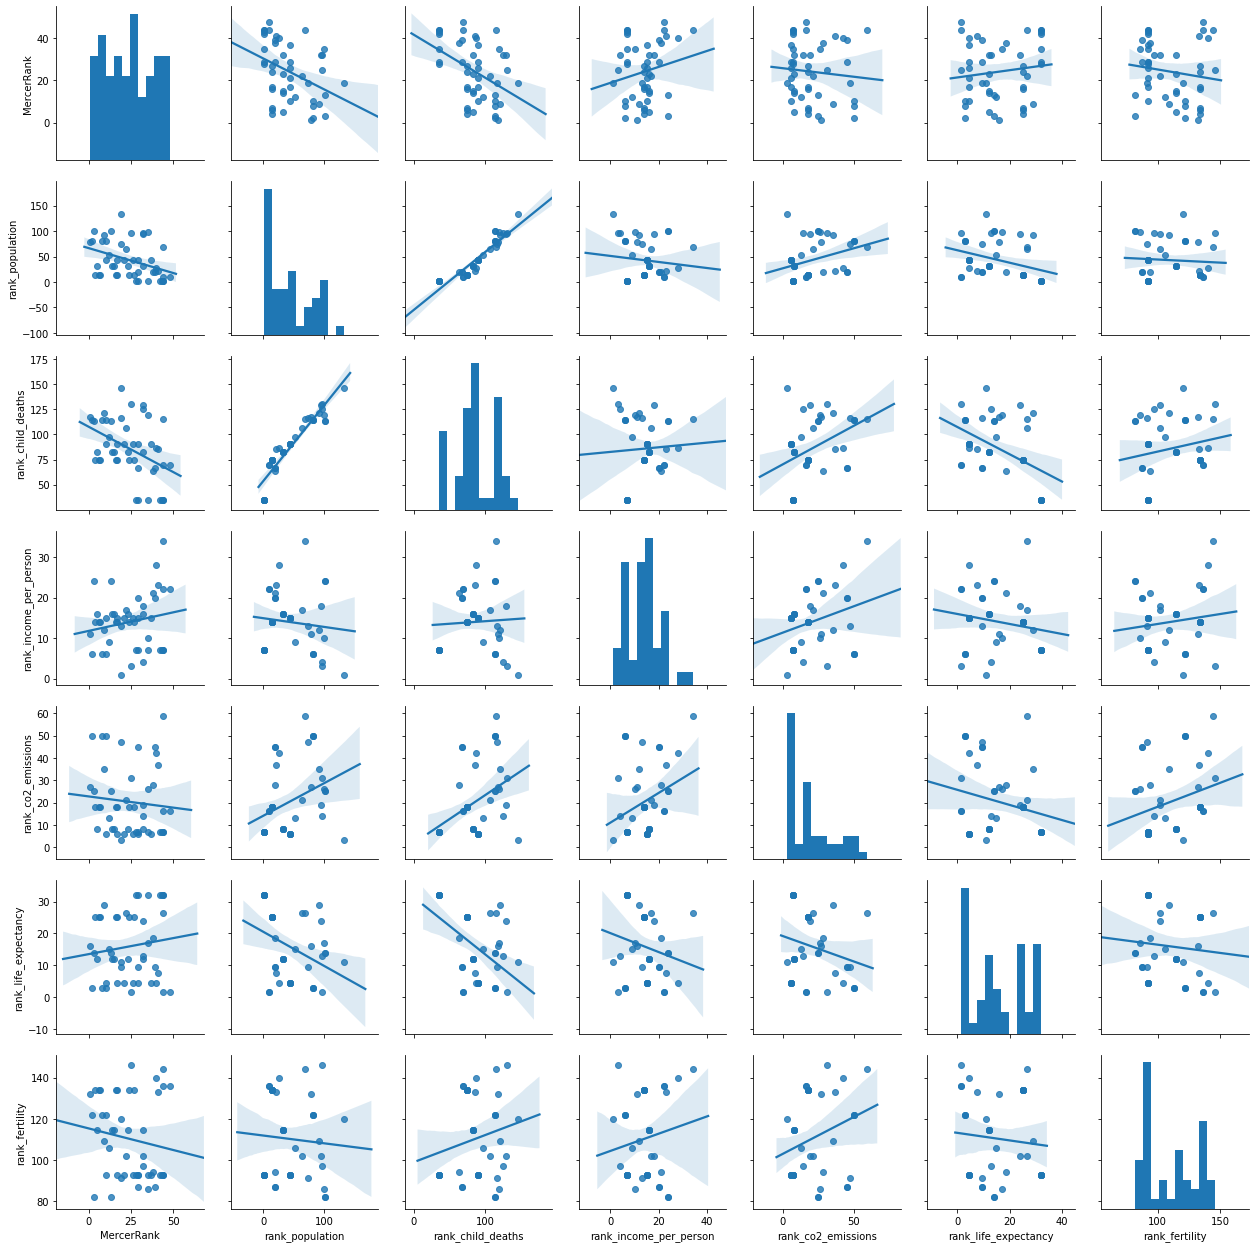

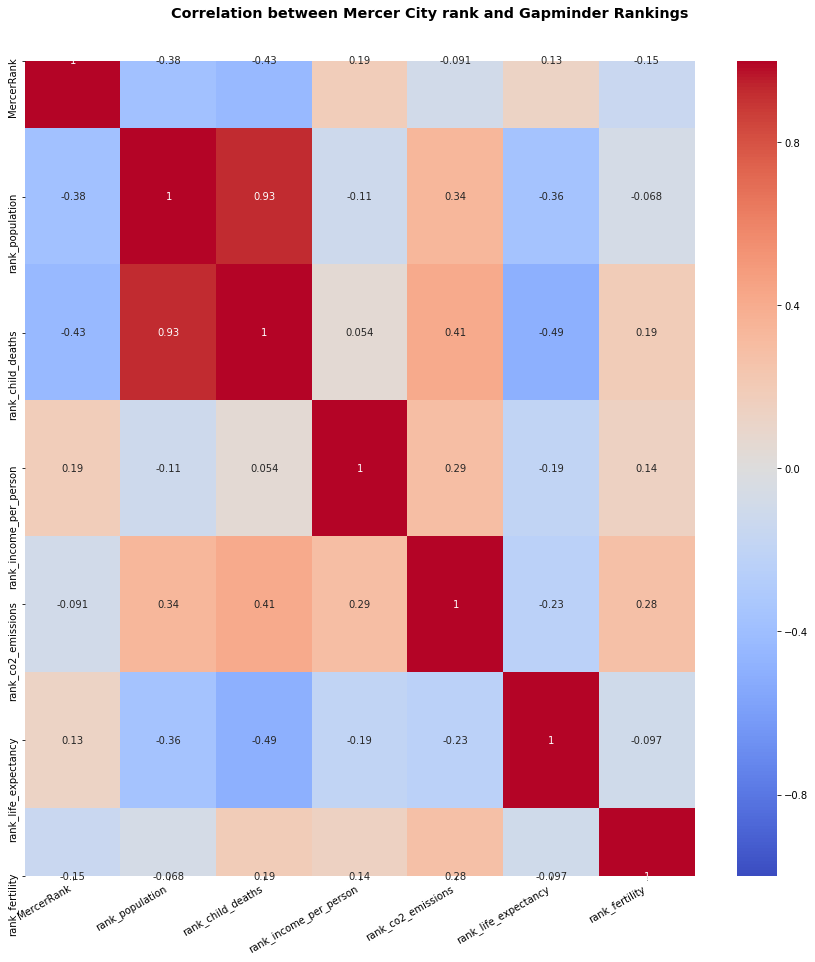

<Figure size 1080x1080 with 0 Axes>

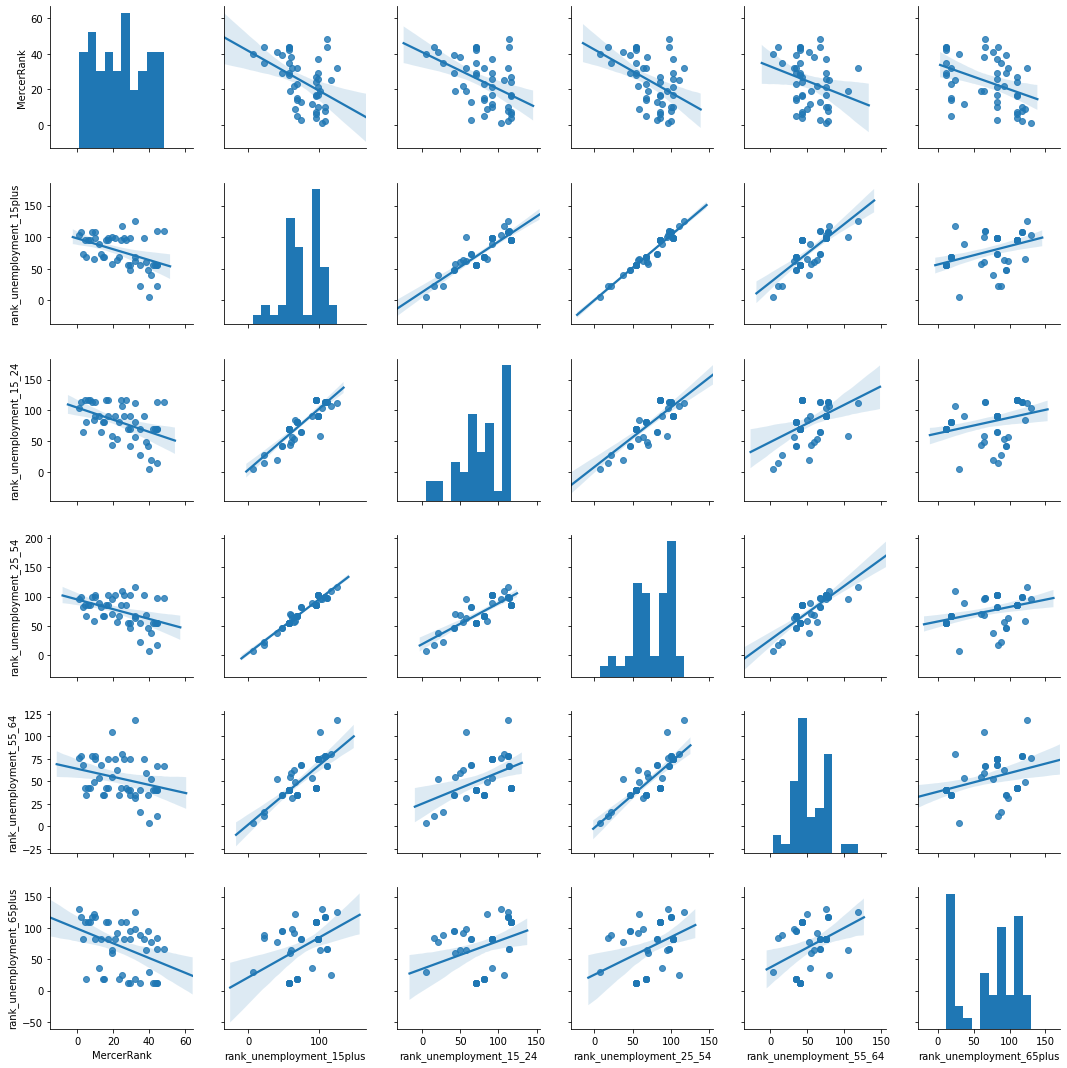

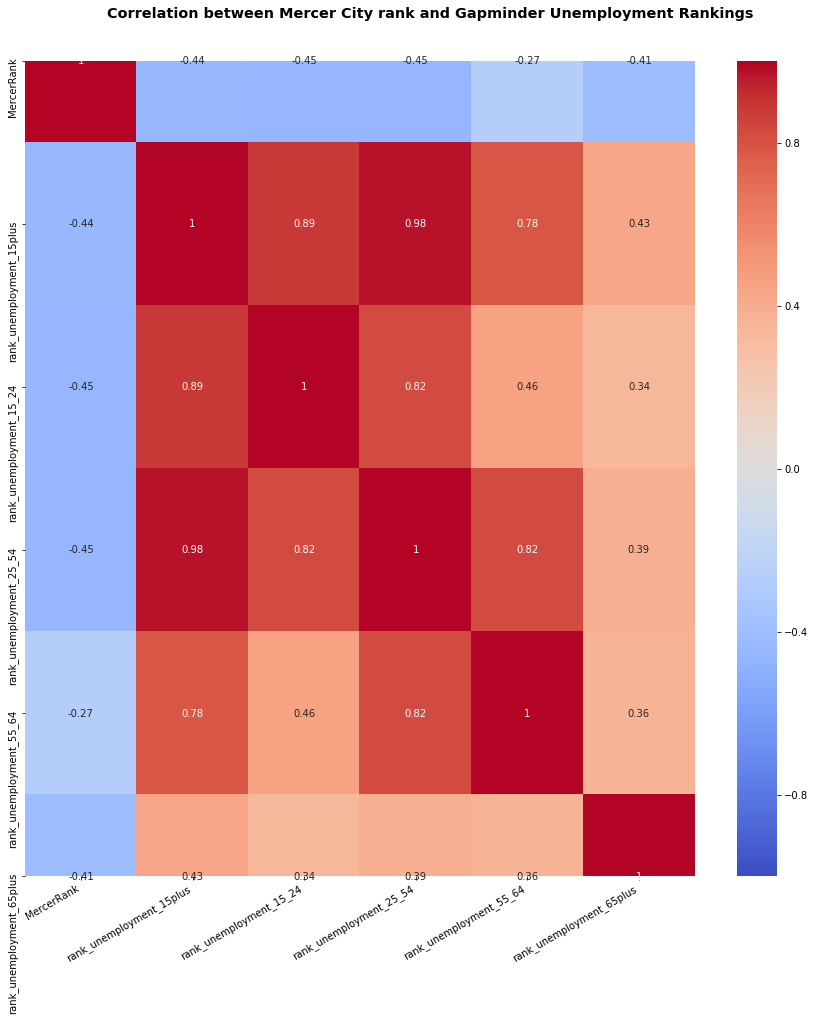

In [12]:
# population, gdp, co2, child_deaths, life_expectency, fertility stats
rank_columns = ['MercerRank', 'rank_population', 'rank_child_deaths', 'rank_income_per_person', 'rank_co2_emissions', 'rank_life_expectancy', 'rank_fertility']
print_scattermatrix(dfMergedMercer.loc[:,rank_columns], "Correlation of Mercer City and Gapminder Rankings")
print_heatmap(dfMergedMercer.loc[:,rank_columns], 'Correlation between Mercer City rank and Gapminder Rankings')
# unemployment stats
rank_columns = ['MercerRank', 'rank_unemployment_15plus', 'rank_unemployment_15_24', 'rank_unemployment_25_54', 'rank_unemployment_55_64', 'rank_unemployment_65plus']
print_scattermatrix(dfMergedMercer.loc[:,rank_columns], 'Correlation between Mercer City rank and Gapminder Unemployment Rankings')
print_heatmap(dfMergedMercer.loc[:,rank_columns], 'Correlation between Mercer City rank and Gapminder Unemployment Rankings')

Correlations with Numbeo

In [13]:
rank_columns = ['country', 'rank_population', 'rank_child_deaths', 'rank_income_per_person', 'rank_co2_emissions', 'rank_life_expectancy', 'rank_fertility', 'rank_unemployment_15plus', 'rank_unemployment_15_24', 'rank_unemployment_25_54', 'rank_unemployment_55_64', 'rank_unemployment_65plus']
dfMergedNumbeo = dfNumbeo2012.merge(dfGapminder[rank_columns], how='left', left_on='Country', right_on='country') 
# print(dfMergedNumbeo.shape)
dfMergedNumbeo.set_index('City',inplace=True)
# dfMergedNumbeo = dfMergedNumbeo.dropna()

Print correlations with Numbeo

c:\dev\binaries\Anaconda3\lib\site-packages\numpy\lib\histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
c:\dev\binaries\Anaconda3\lib\site-packages\numpy\lib\histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


<Figure size 1080x1080 with 0 Axes>

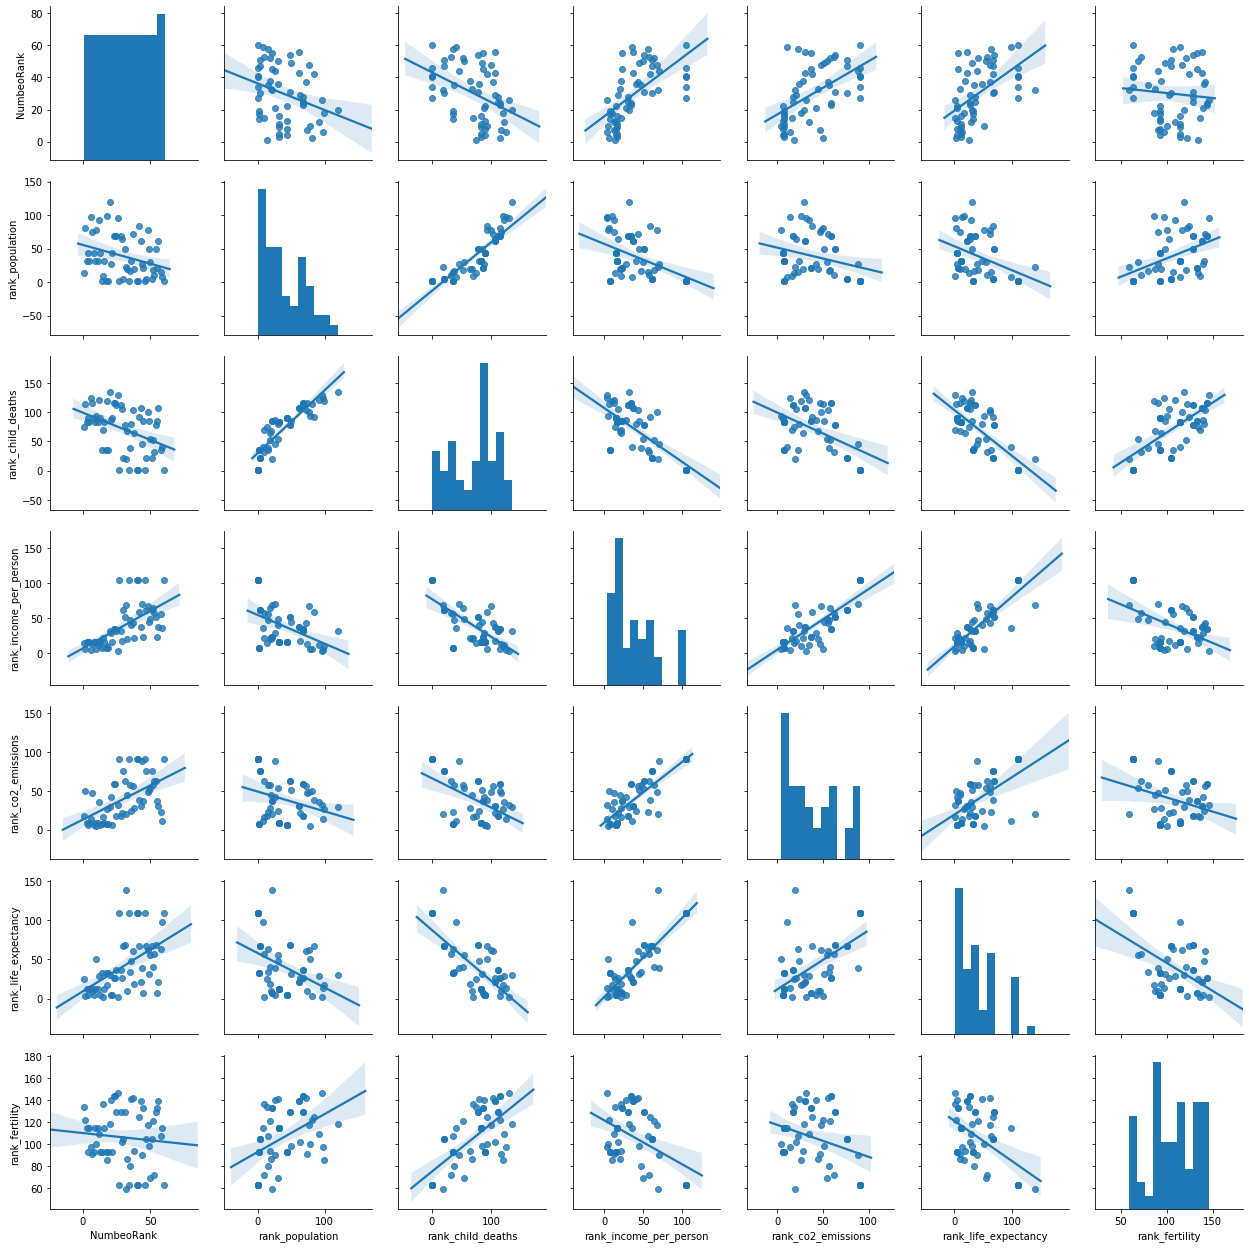

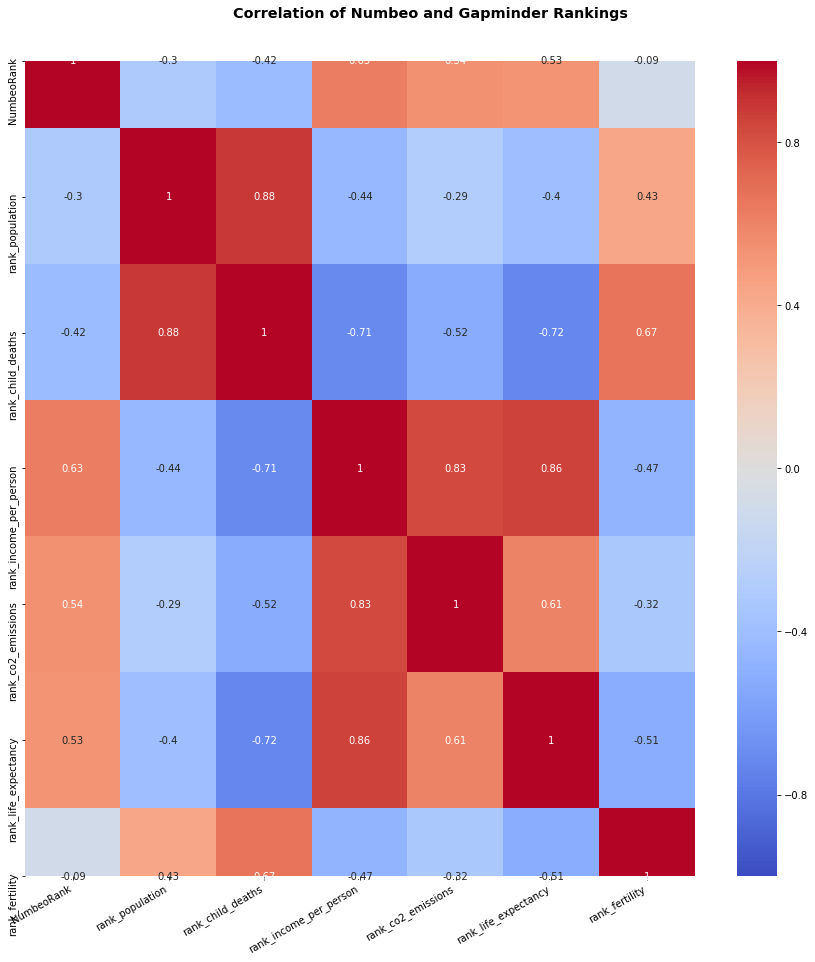

<Figure size 1080x1080 with 0 Axes>

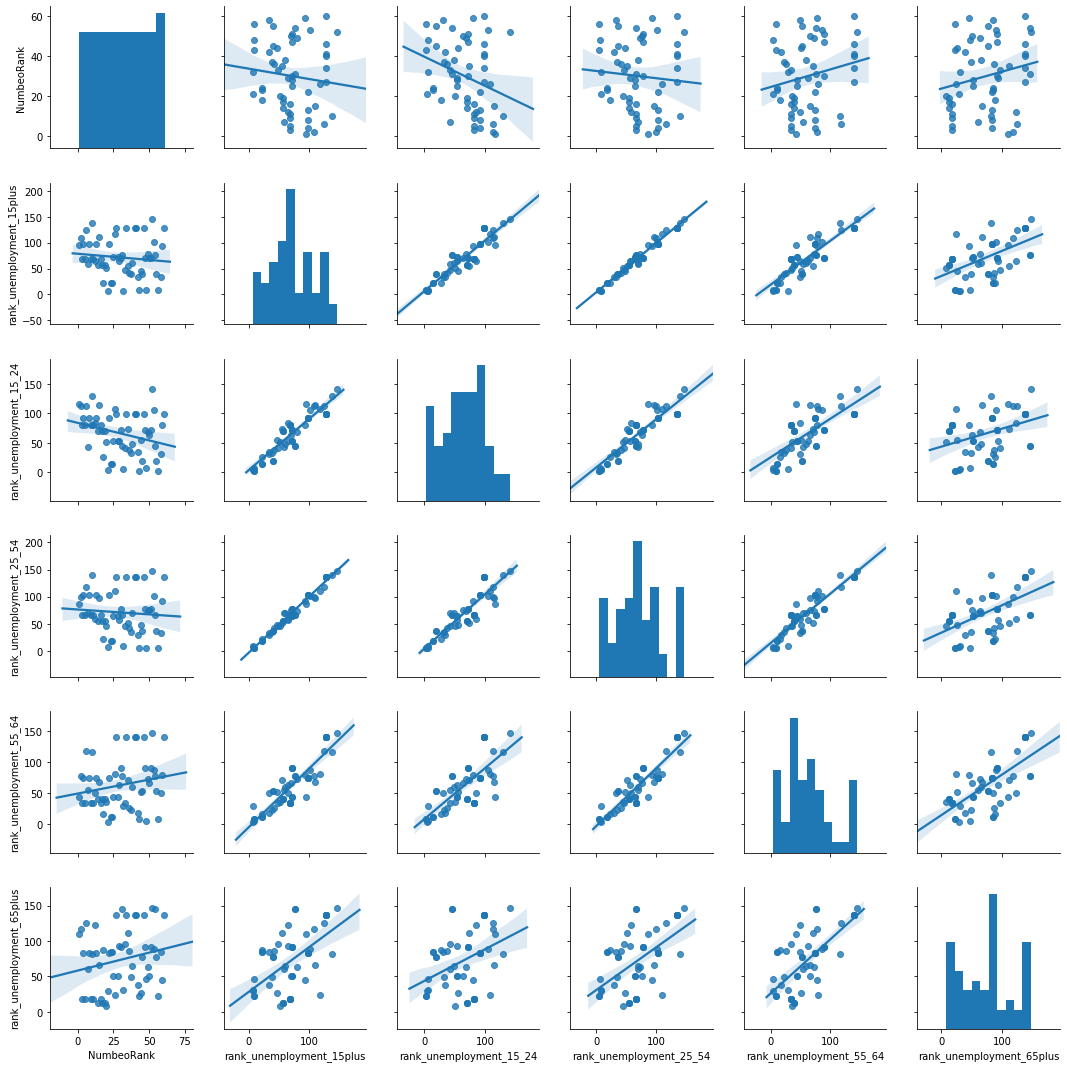

In [14]:
# population, gdp, co2, child_deaths, life_expectency, fertility stats
rank_columns = ['NumbeoRank', 'rank_population', 'rank_child_deaths', 'rank_income_per_person', 'rank_co2_emissions', 'rank_life_expectancy', 'rank_fertility']
print_scattermatrix(dfMergedNumbeo.loc[:,rank_columns], 'Correlation of Numbeo and Gapminder Rankings')
print_heatmap(dfMergedNumbeo.loc[:,rank_columns], 'Correlation of Numbeo and Gapminder Rankings')
# unemployment stats
rank_columns = ['NumbeoRank', 'rank_unemployment_15plus', 'rank_unemployment_15_24', 'rank_unemployment_25_54', 'rank_unemployment_55_64', 'rank_unemployment_65plus']
print_scattermatrix(dfMergedNumbeo.loc[:,rank_columns], 'Correlation of Numbeo and Gapminder Unemployment Rankings')

Correlations with UN Prosperity

In [15]:
rank_columns = ['country', 'rank_population', 'rank_child_deaths', 'rank_income_per_person', 'rank_co2_emissions', 'rank_life_expectancy', 'rank_fertility', 'rank_unemployment_15plus', 'rank_unemployment_15_24', 'rank_unemployment_25_54', 'rank_unemployment_55_64', 'rank_unemployment_65plus']
dfMergedProsperity = dfProsperity2012.merge(dfGapminder[rank_columns], how='left', left_on='Country', right_on='country') 
# print(dfMergedProsperity.shape)
dfMergedProsperity.set_index('City',inplace=True)
dfMergedProsperity = dfMergedProsperity.dropna()

Print correlations with UN Prosperity

<Figure size 1080x1080 with 0 Axes>

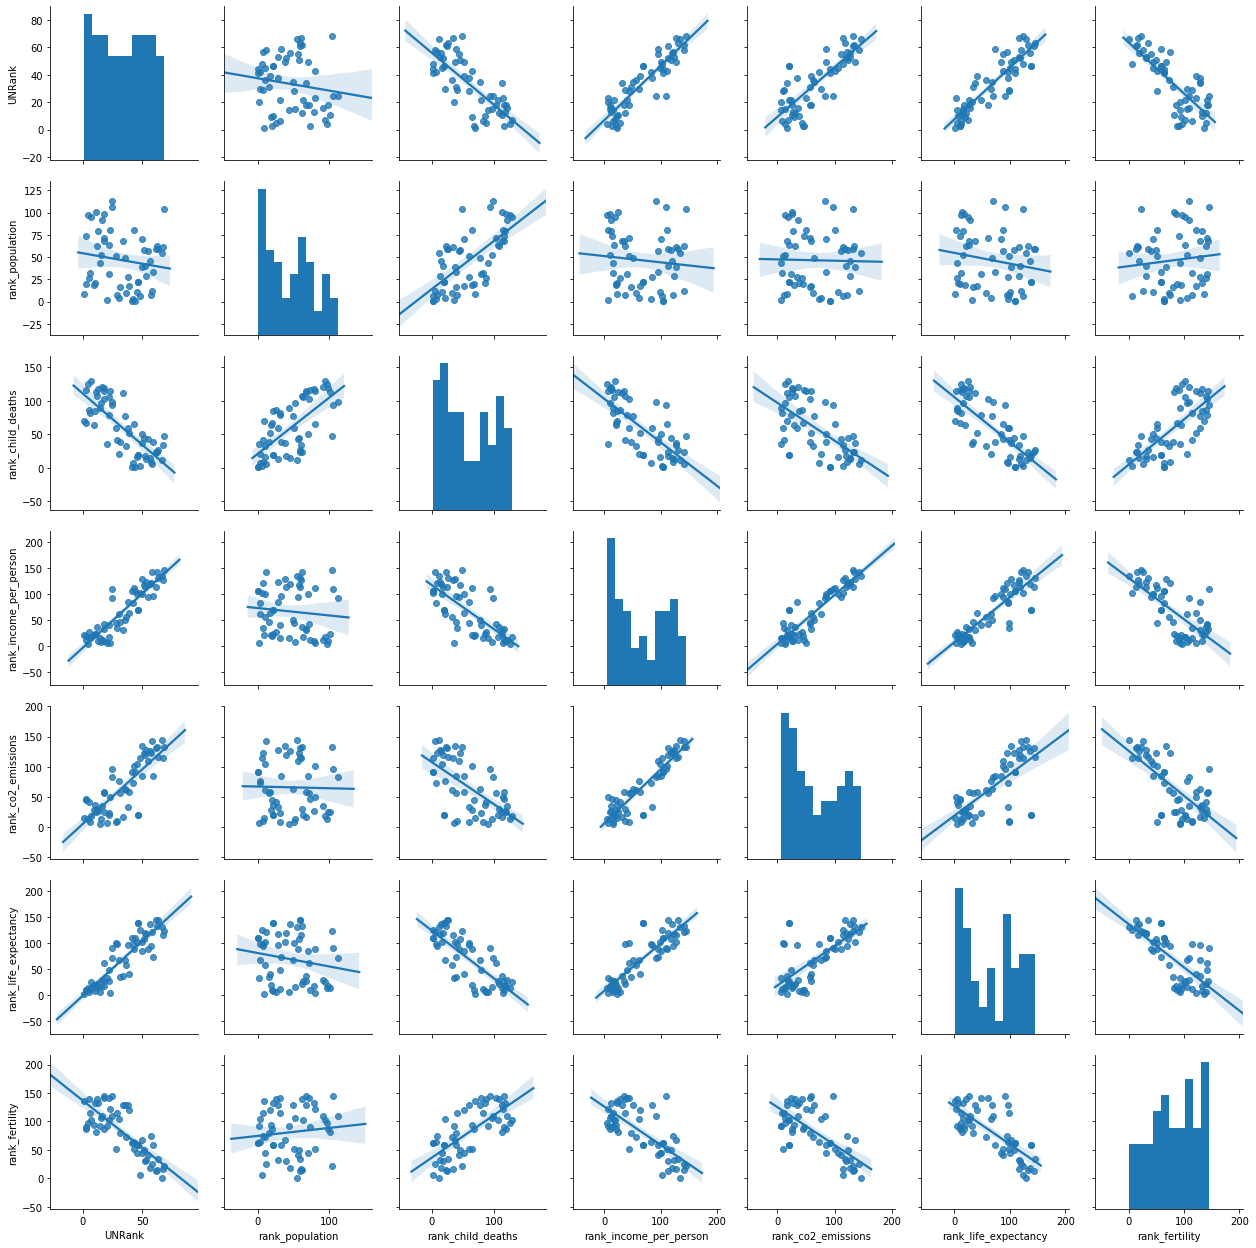

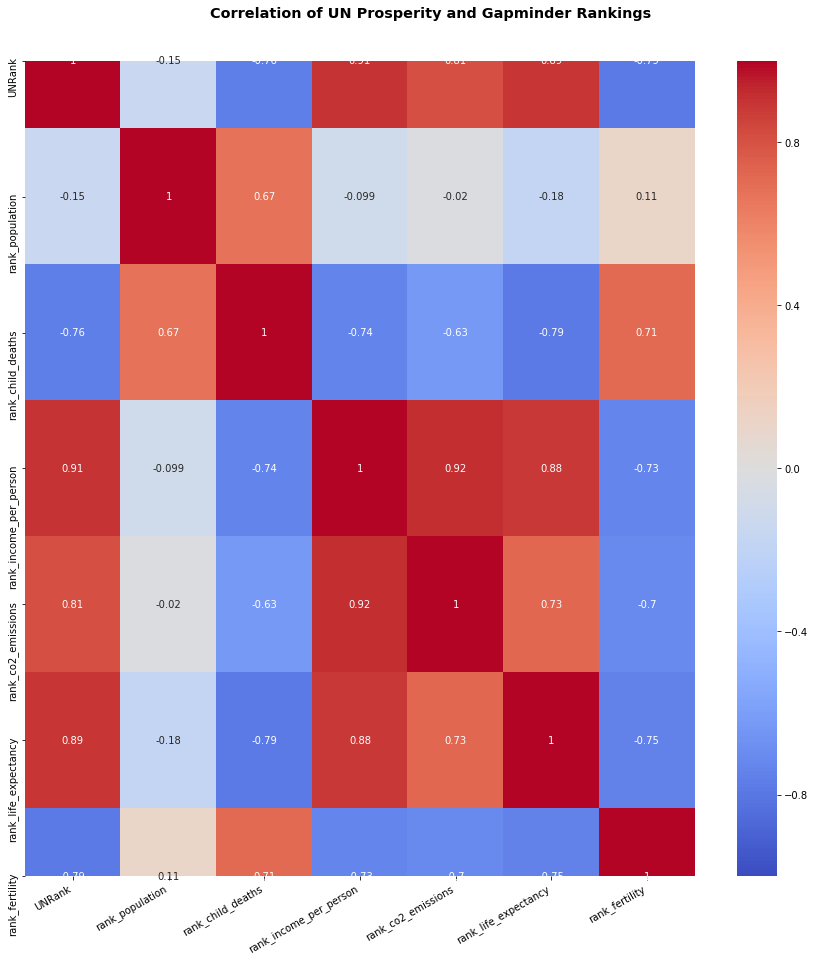

<Figure size 1080x1080 with 0 Axes>

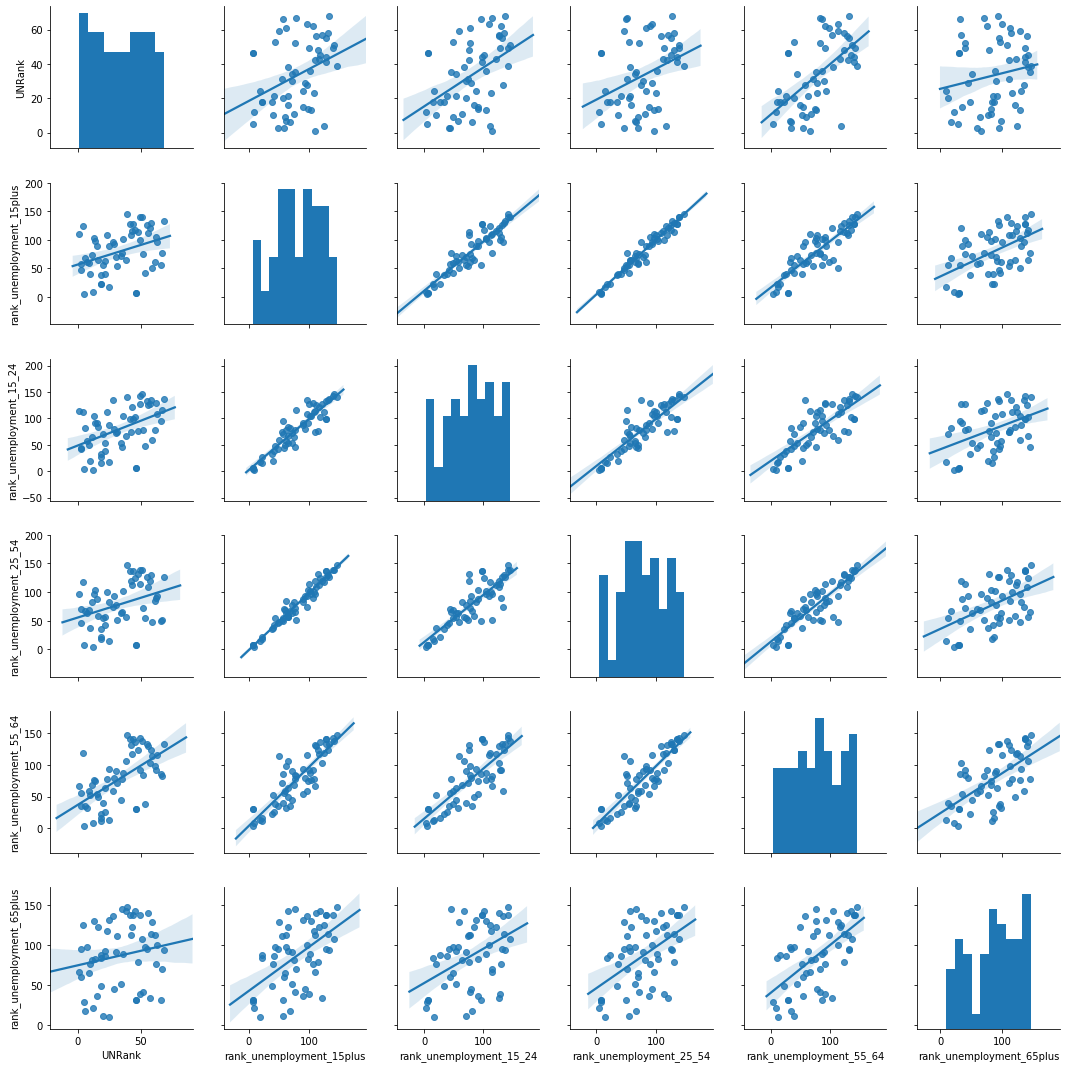

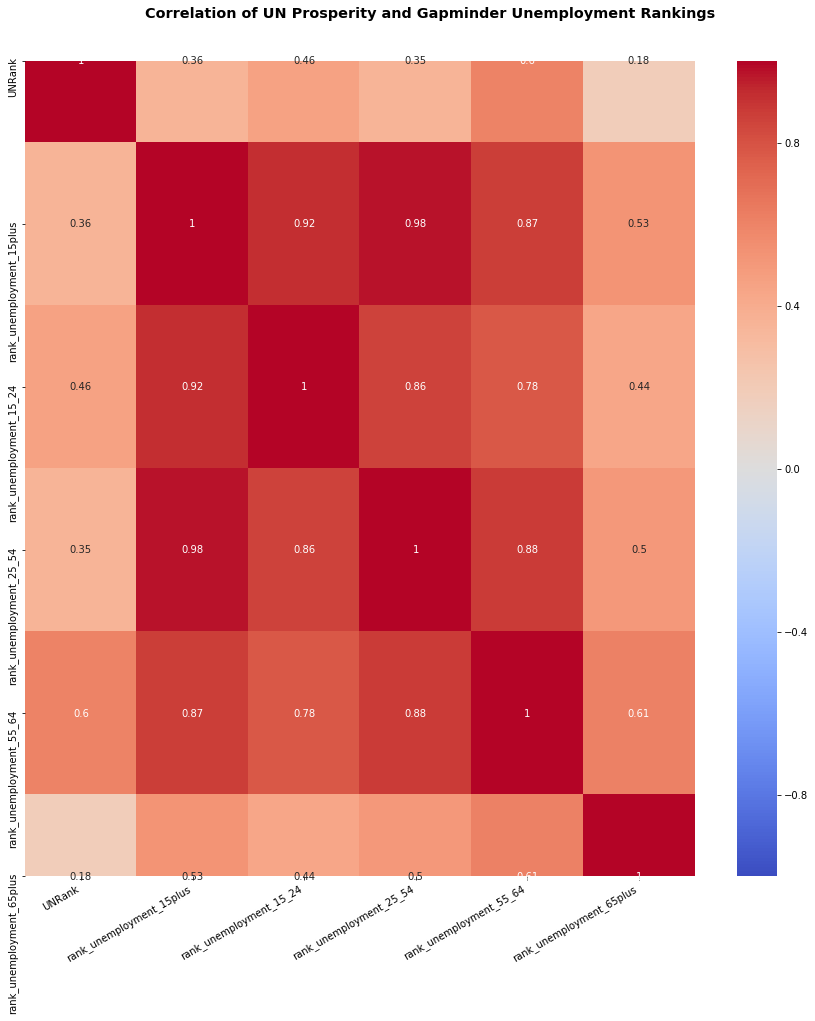

In [16]:
rank_columns = ['UNRank', 'rank_population', 'rank_child_deaths', 'rank_income_per_person', 'rank_co2_emissions', 'rank_life_expectancy', 'rank_fertility']
print_scattermatrix(dfMergedProsperity.loc[:,rank_columns], 'Correlation of UN Prosperity and Gapminder Rankings')
print_heatmap(dfMergedProsperity.loc[:,rank_columns], 'Correlation of UN Prosperity and Gapminder Rankings')
# unemployment stats
rank_columns = ['UNRank', 'rank_unemployment_15plus', 'rank_unemployment_15_24', 'rank_unemployment_25_54', 'rank_unemployment_55_64', 'rank_unemployment_65plus']
print_scattermatrix(dfMergedProsperity.loc[:,rank_columns], 'Correlation of UN Prosperity and Gapminder Unemployment Rankings')
print_heatmap(dfMergedProsperity.loc[:,rank_columns], 'Correlation of UN Prosperity and Gapminder Unemployment Rankings')

## How do the rankings change over time?
As a first step we look at the Numbeo Dataset and analyze the different indices visually over time

In [17]:
display(dfNumbeo)

,Period,City,NumbeoIndex,PurchasingPower,Safety,HealthCare,CostOfLiving,PropertyPriceToIncomeRatio,TrafficCommuteTime,Pollution,Climate,Country
City,,,,,,,,,,,,
Caracas,2020,Caracas,0.00,2.36,15.10,39.28,27.68,150.55,34.69,72.41,99.93,Venezuela
Auckland,2020,Auckland,165.38,83.93,54.54,73.43,76.06,12.09,37.96,29.19,99.89,New Zealand
Guatemala City,2020,Guatemala City,107.71,40.18,37.39,63.63,44.26,9.89,50.11,69.66,99.89,Guatemala
Nairobi,2020,Nairobi,73.29,24.85,39.92,56.46,42.08,26.17,56.94,80.42,99.79,Kenya
Medellin,2020,Medellin,117.13,29.90,48.66,77.28,30.19,17.90,38.29,64.89,99.76,Colombia
...,...,...,...,...,...,...,...,...,...,...,...,...
Cairo,2012-Q1,Cairo,-35.66,18.35,61.33,70.83,52.69,15.51,58.75,129.50,NaN,Egypt
Tehran,2012-Q1,Tehran,-50.44,47.52,43.27,43.40,60.86,13.72,73.50,140.75,NaN,Iran
Moscow,2012-Q1,Moscow,-54.72,46.75,47.33,37.75,86.77,28.06,61.50,116.61,NaN,Russia


## What do these numbers mean? 
The Numbeos Quality of Life Ranking is a weighted index based on several key factors: 

### Purchasing Power
Relative to New York City: If domestic purchasing power is 40, this means that the inhabitants of that city with the average salary can afford to buy on an average 60% less goods and services than New York City residents with an average salary. 

### PropertyPriceToIncomeRatio
Generally calculated as the ratio of median apartment prices to median familial disposable income

### Cost of Living
These indices are relative to New York City (NYC). Which means that for New York City, each index should be 100(%). If another city has, for example, rent index of 120, it means that on an average in that city rents are 20% more expensive than in New York City.

### Pollution, Crime, Health Care
Is based on survey data of visitors. [-2, +2], with -2 having meaning of strongly negative and +2 meaning of strongly positive 

### Climate Index 
Is an estimation of the climate likability of a given city or a country. It is in the range [-100, +100] (higher is better)

### TrafficCommuteTime
Is a composite index of time consumed in traffic due to job commute, estimation of time consumption dissatisfaction, CO2 consumption estimation in traffic and overall inefficiencies in the traffic system

 protected void calculateIndex() {
    index = new TrafficIndex();
    index.time = overall.getTimeOverall();
    double tooMuchTime = 0.0;
    if (index.time > 25.0) {
      tooMuchTime = index.time - 25;
    }
    index.timeExp = index.time + Math.pow(tooMuchTime, Math.E);
    double co2 = 0.0;
    co2 += overall.time_bus * 20.0; // bus produces 20g of CO2 per minute (for each passenger)
    co2 += overall.time_driving * 133.0; // car produces 133g of CO2 per minute (assumes only driver)
    co2 += overall.time_train * 10.0; // train produces 10g of CO2 per minute (for each passenger)
    co2 += overall.time_tram * 15.0; // tram produces 15g of CO2 per minute (for each passenger)
    co2 += overall.time_other * 10.0; // other produces 10g of CO2 per minute
    co2 += overall.time_motorbike * 80.0; // motorbike produces 80g of CO2 per hour
    index.co2 = 2 * co2; 

    index.main = index.time + Math.sqrt(index.timeExp) + Math.sqrt(index.co2) + Math.sqrt(index.inefficiency);
}


### Quality of Life (QoL)
Not the raking is given by the following formular: 
QoL = Math.max(0, 100 + purchasingPowerInclRentIndex / 2.5 - (housePriceToIncomeRatio * 1.0) - costOfLivingIndex / 10 + safetyIndex / 2.0 + healthIndex / 2.5 - trafficTimeIndex / 2.0 - pollutionIndex * 2.0 / 3.0 + climateIndex / 3.0); 

The formular has changed over time. For example between June 2017 and Decembar 2017 they decreased the weight for the cost of living. 
This should be considered when drawing conclusions later! 
Further details can be found on this website: https://www.numbeo.com/quality-of-life/indices_explained.jsp





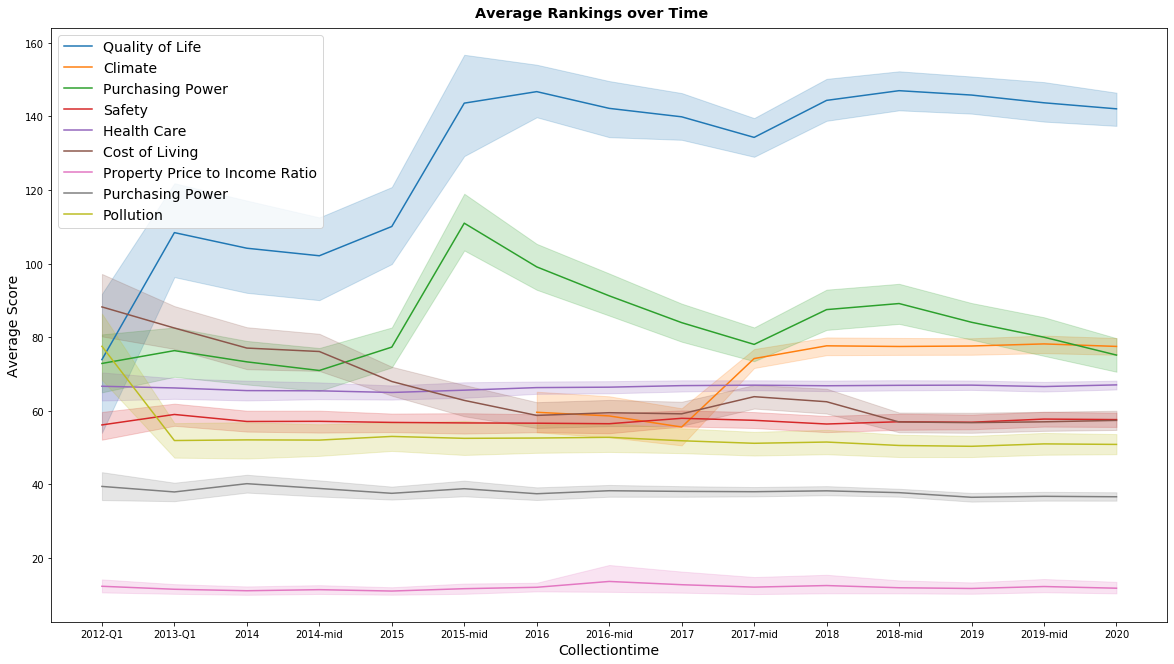

In [18]:
#How do the rankings change over time?

fig = plt.figure(figsize=(20,10))
fig.suptitle('Average Rankings over Time', fontsize='x-large', fontweight='bold')
#This is used for the main title. 'figure()' is a class that provides all the plotting elements of a diagram. 
#This must be used first or else the title will not show.fig.subplots_adjust(top=0.85) solves our overlapping title problem.
fig.subplots_adjust(top=0.95)


ax = fig.add_subplot(111)

fontdict={'fontsize': 14, 'fontweight' : 'book',    'verticalalignment': 'baseline',   'horizontalalignment': 'center'}

#ax.set_title('Plotting Tutorial', fontdict=fontdict)

sns.lineplot(x="Period", y="NumbeoIndex", data=dfNumbeo,legend='brief',label='Quality of Life')
sns.lineplot(x="Period", y="Climate", data=dfNumbeo,legend='brief',label='Climate')
sns.lineplot(x="Period", y="PurchasingPower", data=dfNumbeo,legend='brief',label='Purchasing Power')
sns.lineplot(x="Period", y="Safety", data=dfNumbeo,legend='brief',label='Safety')
sns.lineplot(x="Period", y="HealthCare", data=dfNumbeo,legend='brief',label='Health Care')
sns.lineplot(x="Period", y="CostOfLiving", data=dfNumbeo,legend='brief',label='Cost of Living')
sns.lineplot(x="Period", y="PropertyPriceToIncomeRatio", data=dfNumbeo,legend='brief',label='Property Price to Income Ratio')
sns.lineplot(x="Period", y="TrafficCommuteTime", data=dfNumbeo,legend='brief',label='Purchasing Power')
sns.lineplot(x="Period", y="Pollution", data=dfNumbeo,legend='brief',label='Pollution')

plt.legend(fontsize=14)
#plt.title('Average Rankings over Time', fontdict=fontdict, color="black", position=(0.5,1));
plt.xlabel('Collectiontime', fontsize=14)
plt.ylabel('Average Score', fontsize=14);
fig.savefig('visuals/RankingsOverTime.png')

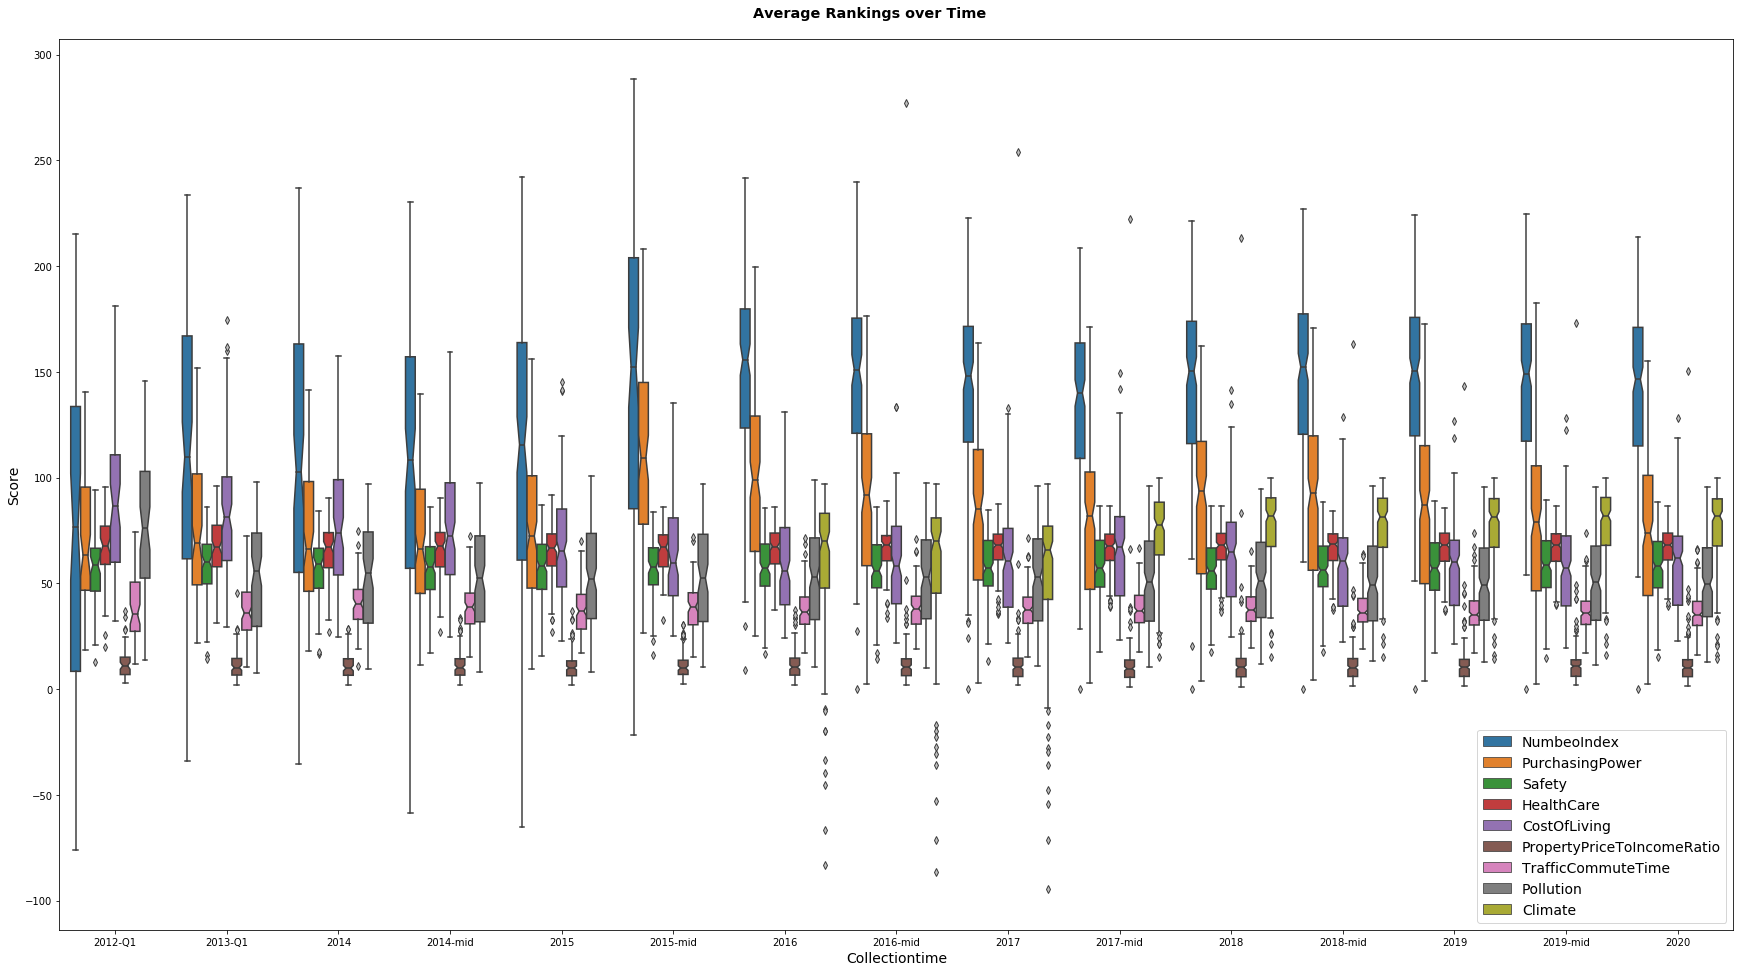

In [19]:
#There might be some outliers in the data so we decided to also look at a boxplot:
fig = plt.figure(figsize=(30,15))
fig.suptitle('Average Rankings over Time', fontsize='x-large', fontweight='bold')
#This is used for the main title. 'figure()' is a class that provides all the plotting elements of a diagram. 
#This must be used first or else the title will not show.fig.subplots_adjust(top=0.85) solves our overlapping title problem.
fig.subplots_adjust(top=0.95)


ax = fig.add_subplot(111)

fontdict={'fontsize': 14, 'fontweight' : 'book',    'verticalalignment': 'baseline',   'horizontalalignment': 'center'}

#ax.set_title('Plotting Tutorial', fontdict=fontdict)

dfNumbeoPivoted = pd.melt(dfNumbeo, col_level=0, id_vars=['Period', 'City'], value_vars=['NumbeoIndex', 'PurchasingPower', 'Safety', 'HealthCare', 'CostOfLiving', 'PropertyPriceToIncomeRatio', 'TrafficCommuteTime','Pollution', 'Climate'])


flierprops = dict(markerfacecolor='0.75', markersize=5,    linestyle='none')
g = sns.boxplot(x="Period", y="value",hue="variable",notch=True, data=dfNumbeoPivoted,order=np.flip(dfNumbeo.Period.unique()),flierprops=flierprops)

plt.legend(fontsize=14)
#plt.title('Average Rankings over Time', fontdict=fontdict, color="black", position=(0.5,1));
plt.xlabel('Collectiontime', fontsize=14)
plt.ylabel('Score', fontsize=14);
fig.savefig('visuals/RankingsOverTimeBoxPlot.png')

## Interpretation
The Quality of life rankings on average increased from 2012 to 2015. Then they decreased a bit till mid 2017 and recovered again to mid 2018. 
After that the quality of life ranking decreased again.


## How do city ratings correlate with quality of life rankings of the country in which the cities are located?


In [20]:
print(f'number numbeo rows {dfNumbeo2012.shape[0]}')
numbeo2012_vs_hdi = pd.merge(dfNumbeo2012, hdi, how='inner', on='Country')
print(f'joined {numbeo2012_vs_hdi.shape[0]} cities from numbeo with countries from hdi')

number numbeo rows 61
joined 61 cities from numbeo with countries from hdi


**Common Correlation Function**

In [21]:
def eval_corr(df, rankA, rankB, title):
    fig = plt.figure(figsize=(13,13))
    g = sns.pairplot(df.loc[:,[rankA,rankB]],kind="reg", diag_kind=None)
    g.fig.suptitle(title, y=0.97,fontsize=14)
    g.fig.subplots_adjust(top=0.85,left=0.2,bottom=0.1)
    g.fig.savefig(f'visuals/CorrelationOf{rankA}vs{rankB}.png')

    spearman_df = spearmanr(df[rankA], df[rankB])
    print(f'spearman relation between {rankA} and {rankB}: {spearman_df}')
    
    df["CityPerformance"] = df[rankA] - df[rankB]
    print(f'10 Cities which perform better than their country ({rankA} vs {rankB})')
    display(df.sort_values("CityPerformance", ascending=True)[["City", "Country", rankA, rankB]].head(10))
    print(f'10 Cities which perform worse than their country ({rankA} vs {rankB})')
    display(df.sort_values("CityPerformance", ascending=False)[["City", "Country", rankA, rankB]].head(10))

### Numbeo Cities vs Human Development Index (HDI) Countries

spearman relation between NumbeoRank and HDIRank(2012): SpearmanrResult(correlation=0.7484288311224342, pvalue=4.099272073255796e-12)
10 Cities which perform better than their country (NumbeoRank vs HDIRank(2012))


,City,Country,NumbeoRank,HDIRank(2012)
27,Bangalore,India,27.0,119.0
28,Pune,India,34.0,119.0
29,Chennai,India,40.0,119.0
30,Delhi,India,41.0,119.0
31,Mumbai,India,46.0,119.0
39,Johannesburg,South Africa,32.0,102.0
32,Kolkata,India,60.0,119.0
34,Curitiba,Brazil,30.0,77.0
57,Cairo,Egypt,57.0,101.0
49,Bogota,Colombia,44.0,76.0


10 Cities which perform worse than their country (NumbeoRank vs HDIRank(2012))


,City,Country,NumbeoRank,HDIRank(2012)
51,Rome,Italy,55.0,23.0
48,Athens,Greece,56.0,27.0
44,London,United Kingdom,38.0,15.0
50,Milan,Italy,45.0,23.0
26,Singapore,Singapore,26.0,7.0
10,Melbourne,Australia,22.0,3.0
33,Brussels,Belgium,29.0,13.0
47,Thessaloniki,Greece,43.0,27.0
40,Paris,France,33.0,21.0
17,New York,United States,19.0,8.0


<Figure size 936x936 with 0 Axes>

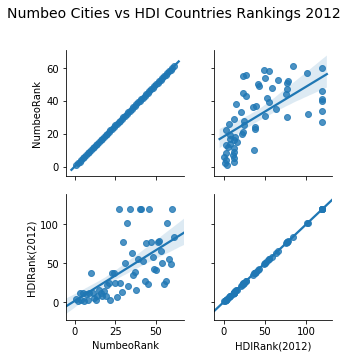

In [22]:
eval_corr(numbeo2012_vs_hdi, 'NumbeoRank', 'HDIRank(2012)', "Numbeo Cities vs HDI Countries Rankings 2012")

### Numbeo Cities vs Human Development Index (HDI) Countries (reranked)

spearman relation between NumbeoRank and HDIReRank(2012): SpearmanrResult(correlation=0.7484288311224342, pvalue=4.099272073255796e-12)
10 Cities which perform better than their country (NumbeoRank vs HDIReRank(2012))


,City,Country,NumbeoRank,HDIReRank(2012)
27,Bangalore,India,27.0,39.0
13,Dubai,United Arab Emirates,10.0,21.0
2,Edmonton,Canada,3.0,9.0
39,Johannesburg,South Africa,32.0,38.0
28,Pune,India,34.0,39.0
3,Calgary,Canada,5.0,9.0
34,Curitiba,Brazil,30.0,34.0
0,Berlin,Germany,1.0,4.0
12,Stockholm,Sweden,7.0,8.0
1,Zurich,Switzerland,2.0,2.0


10 Cities which perform worse than their country (NumbeoRank vs HDIReRank(2012))


,City,Country,NumbeoRank,HDIReRank(2012)
51,Rome,Italy,55.0,16.0
48,Athens,Greece,56.0,19.0
59,Moscow,Russia,59.0,26.0
50,Milan,Italy,45.0,16.0
58,Tehran,Iran,58.0,29.0
38,Bucharest,Romania,54.0,27.0
44,London,United Kingdom,38.0,12.0
54,Buenos Aires,Argentina,50.0,24.0
60,Shanghai,China,61.0,36.0
53,Santiago,Chile,49.0,25.0


<Figure size 936x936 with 0 Axes>

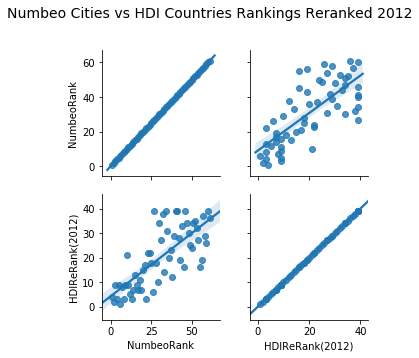

In [23]:
numbeo2012_vs_hdi["HDIReRank(2012)"] = numbeo2012_vs_hdi["HDIRank(2012)"].rank(method='dense', ascending=True) 
eval_corr(numbeo2012_vs_hdi, 'NumbeoRank', 'HDIReRank(2012)', "Numbeo Cities vs HDI Countries Rankings Reranked 2012")

### Numbeo Cities vs Numbeo Countries

joined 61 numbeo cities with countries
spearman relation between NumbeoRank and NumbeoCountryRank: SpearmanrResult(correlation=0.9054556053590573, pvalue=1.2516328518027238e-23)
10 Cities which perform better than their country (NumbeoRank vs NumbeoCountryRank)


,City,Country,NumbeoRank,NumbeoCountryRank
34,Curitiba,Brazil,30.0,44
37,Constanta,Romania,31.0,39
27,Bangalore,India,27.0,33
7,Perth,Australia,4.0,9
2,Edmonton,Canada,3.0,7
3,Calgary,Canada,5.0,7
8,Sydney,Australia,8.0,9
0,Berlin,Germany,1.0,2
28,Pune,India,34.0,33
12,Stockholm,Sweden,7.0,6


10 Cities which perform worse than their country (NumbeoRank vs NumbeoCountryRank)


,City,Country,NumbeoRank,NumbeoCountryRank
32,Kolkata,India,60.0,33
51,Rome,Italy,55.0,31
56,Mexico City,Mexico,53.0,30
44,London,United Kingdom,38.0,18
40,Paris,France,33.0,16
38,Bucharest,Romania,54.0,39
48,Athens,Greece,56.0,42
50,Milan,Italy,45.0,31
54,Buenos Aires,Argentina,50.0,36
31,Mumbai,India,46.0,33


<Figure size 936x936 with 0 Axes>

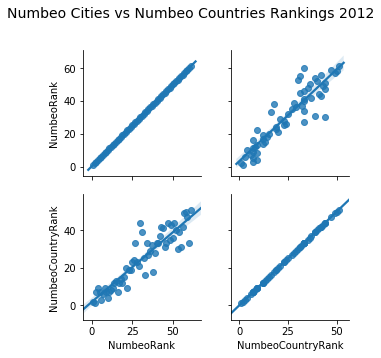

In [24]:
numbeo2012_vs_numbeo2012_countries = pd.merge(dfNumbeo2012, dfNumbeo2012Countries, how='inner', on='Country')
print(f'joined {numbeo2012_vs_numbeo2012_countries.shape[0]} numbeo cities with countries')
eval_corr(numbeo2012_vs_numbeo2012_countries, 'NumbeoRank', 'NumbeoCountryRank', "Numbeo Cities vs Numbeo Countries Rankings 2012")

### Mercer Cities vs Human Development Index (HDI) Countries

joined 48 cities from mercer with countries from hdi
spearman relation between MercerRank and HDIRank(2012): SpearmanrResult(correlation=0.3858741444393683, pvalue=0.006754079985807887)
10 Cities which perform better than their country (MercerRank vs HDIRank(2012))


,City,Country,MercerRank,HDIRank(2012)
0,Vienna,Austria,1,14.0
11,Auckland,New Zealand,3,13.0
13,Vancouver,Canada,5,12.0
1,Zürich,Switzerland,2,2.0
4,Munich,Germany,4,4.0
12,Wellington,New Zealand,13,13.0
26,Luxembourg,Luxembourg,19,18.0
15,Ottawa,Canada,14,12.0
5,Düsseldorf,Germany,6,4.0
14,Toronto,Canada,15,12.0


10 Cities which perform worse than their country (MercerRank vs HDIRank(2012))


,City,Country,MercerRank,HDIRank(2012)
36,New York City,United States,44,8.0
37,Seattle,United States,44,8.0
39,"Washington, D.C.",United States,43,8.0
24,Brisbane,Australia,37,3.0
38,Chicago,United States,42,8.0
47,Kobe,Japan,48,16.0
29,Oslo,Norway,32,1.0
46,Tokyo,Japan,44,16.0
34,Boston,United States,35,8.0
22,Adelaide,Australia,29,3.0


<Figure size 936x936 with 0 Axes>

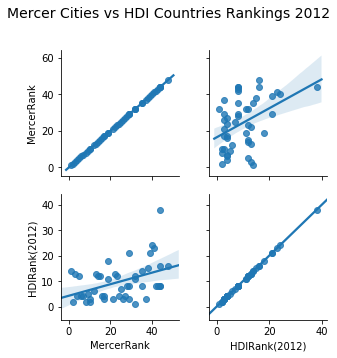

In [25]:
mercer2012_vs_hdi = pd.merge(dfMercer2012, hdi, how='inner', on='Country')
print(f'joined {mercer2012_vs_hdi.shape[0]} cities from mercer with countries from hdi')
eval_corr(mercer2012_vs_hdi, 'MercerRank', 'HDIRank(2012)', "Mercer Cities vs HDI Countries Rankings 2012")

### Mercer Cities vs Numbeo Countries

joined 46 cities from mercer with countries from hdi
spearman relation between MercerRank and NumbeoCountryRank: SpearmanrResult(correlation=0.6846968929649597, pvalue=1.5403400899054224e-07)
10 Cities which perform better than their country (MercerRank vs NumbeoCountryRank)


,City,Country,MercerRank,NumbeoCountryRank
0,Vienna,Austria,1,10
13,Vancouver,Canada,5,7
11,Auckland,New Zealand,3,5
27,Singapore,Singapore,25,24
25,Amsterdam,Netherlands,12,11
19,Sydney,Australia,10,9
18,Copenhagen,Denmark,9,8
29,Brussels,Belgium,22,21
1,Zürich,Switzerland,2,1
4,Munich,Germany,4,2


10 Cities which perform worse than their country (MercerRank vs NumbeoCountryRank)


,City,Country,MercerRank,NumbeoCountryRank
45,Kobe,Japan,48,13
34,New York City,United States,44,12
35,Seattle,United States,44,12
37,"Washington, D.C.",United States,43,12
44,Tokyo,Japan,44,13
36,Chicago,United States,42,12
28,Oslo,Norway,32,3
24,Brisbane,Australia,37,9
38,Lisbon,Portugal,44,19
10,Stuttgart,Germany,27,2


<Figure size 936x936 with 0 Axes>

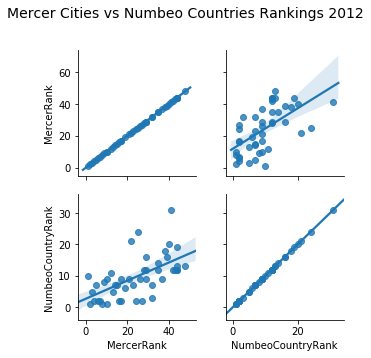

In [26]:
mercer2012_vs_numbeo_countries = pd.merge(dfMercer2012, dfNumbeo2012Countries, how='inner', on='Country')
print(f'joined {mercer2012_vs_numbeo_countries.shape[0]} cities from mercer with countries from hdi')
eval_corr(mercer2012_vs_numbeo_countries, 'MercerRank', 'NumbeoCountryRank', "Mercer Cities vs Numbeo Countries Rankings 2012")

### UN Prosperity Cities vs HDI Countries

joined 69 cities from prosperity with countries from hdi
spearman relation between UNRank and HDIRank(2012): SpearmanrResult(correlation=0.9267292182144561, pvalue=3.435391011305455e-30)
10 Cities which perform better than their country (UNRank vs HDIRank(2012))


,City,Country,UNRank,HDIRank(2012)
44,Niamey,Niger,65.0,175.0
16,Addis Ababa,Ethiopia,58.0,165.0
36,Bamako,Mali,66.0,170.0
22,Conakry,Guinea,62.0,164.0
45,Lagos,Nigeria,48.0,147.0
12,Abidjan,Côte d'Ivoire,64.0,157.0
34,Monrovia,Liberia,68.0,159.0
61,Kampala,Uganda,60.0,150.0
35,Antananarivo,Madagascar,54.0,144.0
53,Dakar,Senegal,67.0,151.0


10 Cities which perform worse than their country (UNRank vs HDIRank(2012))


,City,Country,UNRank,HDIRank(2012)
58,Zurich,Switzerland,23.0,2.0
65,New York,United States,20.0,8.0
1,Melbourne,Australia,14.0,3.0
14,Copenhagen,Denmark,16.0,5.0
13,Prague,Czech Republic,34.0,25.0
42,Amsterdam,Netherlands,15.0,6.0
4,Brussels,Belgium,21.5,13.0
28,Dublin,Ireland,18.0,14.0
46,Oslo,Norway,4.0,1.0
2,Vienna,Austria,13.0,14.0


<Figure size 936x936 with 0 Axes>

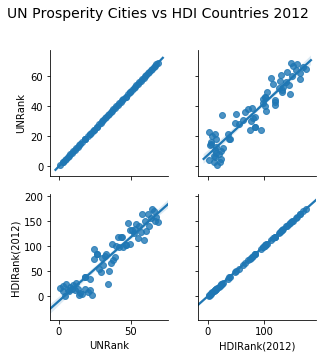

In [27]:
prosperity2012_vs_hdi = pd.merge(dfProsperity2012, hdi, how='inner', on='Country')
print(f'joined {prosperity2012_vs_hdi.shape[0]} cities from prosperity with countries from hdi')
eval_corr(prosperity2012_vs_hdi, 'UNRank', 'HDIRank(2012)', "UN Prosperity Cities vs HDI Countries 2012")

### UN Prosperity Cities vs Numbeo Countries

joined 38 cities from prosperity with countries from numbeo
spearman relation between UNRank and NumbeoCountryRank: SpearmanrResult(correlation=0.6276892992568064, pvalue=2.4630131615641274e-05)
10 Cities which perform better than their country (UNRank vs NumbeoCountryRank)


,City,Country,UNRank,NumbeoCountryRank
11,Athens,Greece,12.0,42
5,Beijing,China,26.5,51
6,Shanghai,China,26.5,51
17,Milan,Italy,10.0,31
27,Moscow,Russia,29.0,47
30,Barcelona,Spain,5.0,20
12,Budapest,Hungary,18.0,32
3,São Paulo,Brazil,30.0,44
10,Paris,France,2.5,16
18,Tokyo,Japan,1.0,13


10 Cities which perform worse than their country (UNRank vs NumbeoCountryRank)


,City,Country,UNRank,NumbeoCountryRank
32,Zurich,Switzerland,23.0,1
29,Johannesburg,South Africa,46.5,25
28,Cape Town,South Africa,46.5,25
7,Prague,Czech Republic,34.0,23
14,New Delhi,India,44.0,33
37,New York,United States,20.0,12
13,Mumbai,India,41.0,33
15,Jakarta,Indonesia,42.0,34
8,Copenhagen,Denmark,16.0,8
21,Auckland,New Zealand,11.0,5


<Figure size 936x936 with 0 Axes>

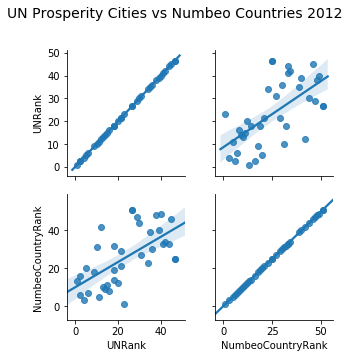

In [28]:
prosperity2012_vs_hdi = pd.merge(dfProsperity2012, dfNumbeo2012Countries, how='inner', on='Country')
print(f'joined {prosperity2012_vs_hdi.shape[0]} cities from prosperity with countries from numbeo')
eval_corr(prosperity2012_vs_hdi, 'UNRank', 'NumbeoCountryRank', "UN Prosperity Cities vs Numbeo Countries 2012")


## How do these rankings correlate with each other for one specific year?

In [29]:
mergedDf = dfMercer2012.merge(dfNumbeo2012, left_index=True, right_index=True)

#now that we operate on a subset of the data we should rerank the cities to have comparable ranks! 
#otherwise we would have higher ranks for numbeo cities because we have more data there and our goal is to see if numbeo would sort the cities in the same order as mercer does. 
mergedDf["NumbeoReRank"] = mergedDf["NumbeoRank"].rank(ascending=False) 
mergedDf["MercerReRank"] = mergedDf["MercerRank"].rank(ascending=False) 
mergedDf.to_csv("data/NumbeoAndMercer.csv", index=False)
mergedDf

,City_x,Country_x,MercerIndex,Year,MercerRank,Period,City_y,NumbeoIndex,PurchasingPower,Safety,HealthCare,CostOfLiving,PropertyPriceToIncomeRatio,TrafficCommuteTime,Pollution,Climate,Country_y,NumbeoRank,NumbeoReRank,MercerReRank
City,,,,,,,,,,,,,,,,,,,,
Vancouver,Vancouver,Canada,107.4,2012,5,2012-Q1,Vancouver,133.65,95.55,61.65,84.72,110.81,10.42,40.00,52.50,NaN,Canada,16.0,9.0,20.0
Copenhagen,Copenhagen,Denmark,106.2,2012,9,2012-Q1,Copenhagen,155.40,95.37,54.69,89.81,129.34,6.26,36.67,34.17,NaN,Denmark,12.0,13.0,19.0
Sydney,Sydney,Australia,106.3,2012,10,2012-Q1,Sydney,165.67,100.96,72.80,78.33,139.12,8.63,46.70,25.62,NaN,Australia,8.0,16.0,18.0
Berlin,Berlin,Germany,105.0,2012,16,2012-Q1,Berlin,215.25,140.62,77.34,64.81,89.06,5.74,23.00,40.00,NaN,Germany,1.0,20.0,16.0
Toronto,Toronto,Canada,105.3,2012,15,2012-Q1,Toronto,159.07,105.78,68.23,70.56,106.58,7.65,38.09,42.50,NaN,Canada,11.0,14.0,17.0
Melbourne,Melbourne,Australia,104.8,2012,17,2012-Q1,Melbourne,107.12,97.41,45.98,72.22,125.54,10.49,31.56,64.03,NaN,Australia,22.0,7.0,15.0
Perth,Perth,Australia,104.2,2012,21,2012-Q1,Perth,196.00,118.34,48.75,87.04,142.18,5.24,27.00,15.00,NaN,Australia,4.0,19.0,13.0
Montreal,Montreal,Canada,104.2,2012,23,2012-Q1,Montreal,164.99,114.23,70.88,70.50,99.58,3.95,32.17,58.75,NaN,Canada,9.0,15.0,11.0
Stockholm,Stockholm,Sweden,104.5,2012,19,2012-Q1,Stockholm,166.05,84.85,73.44,85.65,118.21,11.36,30.67,20.00,NaN,Sweden,7.0,17.0,14.0


<Figure size 936x936 with 0 Axes>

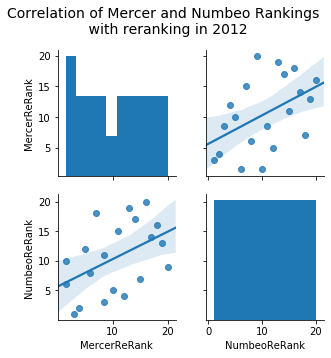

In [30]:
fig = plt.figure(figsize=(13,13))
g = sns.pairplot(mergedDf.loc[:,['MercerReRank','NumbeoReRank']],kind="reg")
g.fig.suptitle("Correlation of Mercer and Numbeo Rankings \n with reranking in 2012", y=0.97,fontsize=14)
g.fig.subplots_adjust(top=0.85,left=0.2,bottom=0.1)
g.fig.savefig('visuals/CorrelationOfMercerAndNumbeoRanking2012withreranking.png')



<Figure size 720x720 with 0 Axes>

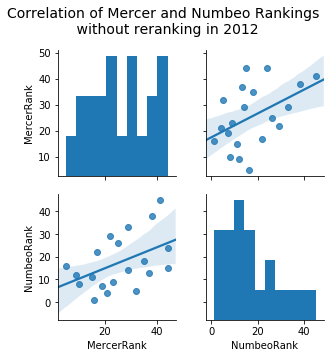

In [31]:
fig = plt.figure(figsize=(10,10))
g = sns.pairplot(mergedDf.loc[:,['MercerRank','NumbeoRank']],kind="reg")
g.fig.suptitle("Correlation of Mercer and Numbeo Rankings \n without reranking in 2012", y=0.97,fontsize=14)
g.fig.subplots_adjust(top=0.85,left=0.2,bottom=0.1)
g.fig.savefig('visuals/CorrelationOfMercerAndNumbeoRanking2012withoutreranking.png')



In [32]:
%load_ext rpy2.ipython

ModuleNotFoundError: No module named 'rpy2'

In [ ]:
%%R -o output
d <- read.csv2("data/NumbeoAndMercer.csv",sep=',',dec ='.')
rankcorrelation <- cor(d$NumbeoReRank, d$MercerReRank,  method = "spearman", use = "complete.obs")
indexcorrelation <- cor(d$NumbeoIndex, d$MercerIndex,  method = "spearman", use = "complete.obs")
output <- capture.output({c(rankcorrelation,indexcorrelation) })

In [ ]:
print(output)

## Insight
Interesting to see that Mercer Rankings correlate with Numbeo Rankings. Especially because Mercers sells the ranking data for 20k and Numbeo is (almost) for free. 

In [ ]:
mergedDf = mergedDf.merge(dfProsperity2012, left_index=True, right_index=True) 
mergedDf["UNReRank"] = mergedDf["UNRank"].rank(ascending=False) 
mergedDf

In [ ]:
fig = plt.figure(figsize=(10,10))
g = sns.pairplot(mergedDf.loc[:,['MercerReRank','NumbeoReRank','UNReRank']],kind="reg")
g.fig.suptitle("Correlation of Mercer, UN and Numbeo Rankings in 2012", y=0.97,fontsize=14)
g.fig.subplots_adjust(top=0.9)
g.fig.savefig('visuals/CorrelationOfMercerAndUNAndNumbeoRanking2012.png')


In [ ]:
#Todo merging only Numbeo with UN Data! (Removing the bottleneck Mercer)
mergedDf = dfProsperity2012.merge(dfNumbeo2012, left_index=True, right_index=True)
mergedDf["NumbeoReRank"] = mergedDf["NumbeoRank"].rank(ascending=False) 
mergedDf["UNReRank"] = mergedDf["UNRank"].rank(ascending=False) 
mergedDf

In [ ]:
fig = plt.figure(figsize=(10,10))

g = sns.pairplot(mergedDf.loc[:,['NumbeoReRank','UNReRank']],kind="reg")
g.fig.suptitle("Correlation of UN and Numbeo Rankings in 2012", y=0.97,fontsize=14)
g.fig.subplots_adjust(top=0.9)
g.fig.savefig('visuals/CorrelationOfUNAndNumbeoRanking2012.png')

## How do they correlate with other statistics about the countries in which the cities are located? 

## What are the determining characteristics for livability of a city? How do they correlate with cost of living?

In [ ]:
#for this question we will look at the most recent Numbeo data (2020) and make a visual analysis. 
#after that we will train a linear regression model in r and interpret the inference statistics

dfNumbeo2020 = dfNumbeo.set_index('Period').loc['2020',:]
#dfNumbeo2020


#There might be some outliers in the data so we decided to also look at a boxplot:
#fig = plt.figure(figsize=(12,10))
#fig.suptitle('Correlation of City Characteristics', fontsize='x-large', fontweight='bold', y=0.93)
#This is used for the main title. 'figure()' is a class that provides all the plotting elements of a diagram. 
#This must be used first or else the title will not show.fig.subplots_adjust(top=0.85) solves our overlapping title problem.


fig = plt.figure(figsize=(30,15))
#fig.suptitle('Correlation of Rankings in 2020', fontsize='x-large', fontweight='bold')
#fig.subplots_adjust(top=0.88,left=0.2,bottom=0.3)

#ax = fig.add_subplot(111)
g = sns.pairplot(dfNumbeo2020,kind="reg")
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle("Correlation of Rankings with outliers in 2020", y=0.97,fontsize=14)

# plt.title('Correlation of Rankings in 2020', fontdict=fontdict, color="black", position=(0.5,1));

g.fig.savefig('visuals/CorrelationOfRankingsIn2020WithOutliers.png')


In [ ]:
#find the outliers
#taken from https://stackoverflow.com/questions/46827580/multivariate-outlier-removal-with-mahalanobis-distance
def MahalanobisDist(data, verbose=False):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            vars_mean = []
            for i in range(data.shape[0]):
                vars_mean.append(list(data.mean(axis=0)))
            diff = data - vars_mean
            md = []
            for i in range(len(diff)):
                md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))

            if verbose:
                print("Covariance Matrix:\n {}\n".format(covariance_matrix))
                print("Inverse of Covariance Matrix:\n {}\n".format(inv_covariance_matrix))
                print("Variables Mean Vector:\n {}\n".format(vars_mean))
                print("Variables - Variables Mean Vector:\n {}\n".format(diff))
                print("Mahalanobis Distance:\n {}\n".format(md))
            return md
        else:
            print("Error: Inverse of Covariance Matrix is not positive definite!")
    else:
        print("Error: Covariance Matrix is not positive definite!")


def MD_detectOutliers(data, extreme=False, verbose=False):
    MD = MahalanobisDist(data, verbose)
    # one popular way to specify the threshold
    #m = np.mean(MD)
    #t = 3. * m if extreme else 2. * m
    #outliers = []
    #for i in range(len(MD)):
    #    if MD[i] > t:
    #        outliers.append(i)  # index of the outlier
    #return np.array(outliers)

    # or according to the 68–95–99.7 rule
    std = np.std(MD)
    k = 3. * std if extreme else 2. * std
    m = np.mean(MD)
    up_t = m + k
    low_t = m - k
    outliers = []
    for i in range(len(MD)):
        if (MD[i] >= up_t) or (MD[i] <= low_t):
            outliers.append(i)  # index of the outlier
    return np.array(outliers)


def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False


def handle_outliers(noisy_data):
    """ 
    Parameters
    --------
    noisy_data: data frame that contains outliers
    
    Returns
    --------
    cleaned_data: data frame with outliers
    """
    df = noisy_data 
    #using a multivariate outlier detection based on mahalanobis distance from 
    #https://stackoverflow.com/questions/46827580/multivariate-outlier-removal-with-mahalanobis-distance
    outliers_indices = MD_detectOutliers(df.iloc[:,2:10].values, verbose=False)

    print("Outliers Indices: {}\n".format(outliers_indices))
    df = df.reset_index()
    inliers = pd.Int64Index(np.arange(len(df))).difference(outliers_indices)
    cleaned_data = df.iloc[inliers]
    return cleaned_data
    
dfNumbeo2020_cleaned = handle_outliers(dfNumbeo2020).set_index('Period')


In [ ]:
#looking at the outliers:
dfNumbeo2020.iloc[[0,226],:]

In [ ]:
#plotting again without outliers
#dfNumbeo2020_cleaned

fig = plt.figure(figsize=(30,15))
#fig.suptitle('Correlation of Rankings in 2020', fontsize='x-large', fontweight='bold')

#ax = fig.add_subplot(111)
g = sns.pairplot(dfNumbeo2020_cleaned,kind="reg")
g.fig.suptitle("Correlation of Rankings in 2020", y=0.97,fontsize=14)
g.fig.subplots_adjust(top=0.95)

# plt.title('Correlation of Rankings in 2020', fontdict=fontdict, color="black", position=(0.5,1));

g.fig.savefig('visuals/CorrelationOfRankingsIn2020.png')


In [ ]:
#plotting subset of the features that lead to an increase of the cost of living:
fig = plt.figure(figsize=(30,15))
#fig.suptitle('Correlation of Rankings in 2020', fontsize='x-large', fontweight='bold')

#ax = fig.add_subplot(111)
g = sns.pairplot(dfNumbeo2020_cleaned.loc[:,['CostOfLiving','NumbeoIndex','PurchasingPower','HealthCare']],kind="reg")
g.fig.suptitle("Cost of living vs city characteristics in 2020 - increasing factors", y=0.97,fontsize=14)
g.fig.subplots_adjust(top=0.95)

# plt.title('Correlation of Rankings in 2020', fontdict=fontdict, color="black", position=(0.5,1));

g.fig.savefig('visuals/CostOfLivingCorrelationIn2020.png')


In [ ]:
#plotting subset of the features that lead to a decrease of the cost of living:
fig = plt.figure(figsize=(30,15))
#fig.suptitle('Correlation of Rankings in 2020', fontsize='x-large', fontweight='bold')

#ax = fig.add_subplot(111)
g = sns.pairplot(dfNumbeo2020_cleaned.loc[:,['CostOfLiving','PropertyPriceToIncomeRatio','TrafficCommuteTime','Pollution']],kind="reg")
g.fig.suptitle("Cost of living vs city characteristics in 2020 - decreasing factors", y=0.97,fontsize=14)
g.fig.subplots_adjust(top=0.95)

# plt.title('Correlation of Rankings in 2020', fontdict=fontdict, color="black", position=(0.5,1));

g.fig.savefig('visuals/CostOfLivingCorrelationIn2020NegativeInfluencers.png')


In [ ]:
dfNumbeo2020_cleaned.to_csv('data/NumbeoOutlierRemoved.csv')

In [ ]:
#There might be some outliers in the data so we decided to also look at a boxplot:
fig = plt.figure(figsize=(12,10))
fig.suptitle('Correlation of City Characteristics', fontsize='x-large', fontweight='bold', y=0.93)
#This is used for the main title. 'figure()' is a class that provides all the plotting elements of a diagram. 
#This must be used first or else the title will not show.fig.subplots_adjust(top=0.85) solves our overlapping title problem.
fig.subplots_adjust(top=0.88,left=0.2,bottom=0.3)


ax = fig.add_subplot(111)

fontdict={'fontsize': 14, 'fontweight' : 'book',    'verticalalignment': 'baseline',   'horizontalalignment': 'center'}

#ax.set_title('Plotting Tutorial', fontdict=fontdict)

g = sns.heatmap(dfNumbeo2020_cleaned.corr(),  vmin=-1, cmap='coolwarm', annot=True);

plt.legend(fontsize=14)
#plt.title('Average Rankings over Time', fontdict=fontdict, color="black", position=(0.5,1));
plt.xlabel('', fontsize=14)
plt.ylabel('', fontsize=14);
fig.savefig('visuals/CorrelationOfCityCharacteristics.png')

In [ ]:
#g = sns.boxplot(x="Period", y="value",hue="variable", data=dfNumbeoPivoted,order=np.flip(dfNumbeo.Period.unique()))
#dir(g)

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R -o output
d <- read.csv2("data/NumbeoOutlierRemoved.csv",sep=',',dec ='.')
n <- nrow(d)
set.seed(123)
train <- sample(1:n,round(n*2/3))


res <- lm(CostOfLiving~PurchasingPower+Safety+HealthCare+PropertyPriceToIncomeRatio+TrafficCommuteTime+Pollution+Climate,data=d[train,])
summary(res)
output <- capture.output({summary(res) })


In [ ]:
print(output)

## Interpretation

From the visual analysis we see that there is a strong postive correlation of the cost of living and the quality of life, purchasing power and safety.

The higher the cost of living the lower is the ratio between the property prices and the income. Also the cost of living is lower when the commute time index or the pollution is high.
In addition when the climate is nice the cost of living tends to be higher. This is also confirmed by the inference statistics of the simple regression model. 

The model shows coefficients significant from 0 for all indices. 


And interesting insight is that in order to get good health care you not necessarly have to have high cost of living.


## Are there cities with a higher healthcare ranking and lower cost of living as Vienna?


In [ ]:
ViennaHealthCare = dfNumbeo2020_cleaned.loc[dfNumbeo2020_cleaned.City == 'Vienna','HealthCare'].values[0]
ViennaCostOfLiving = dfNumbeo2020_cleaned.loc[dfNumbeo2020_cleaned.City == 'Vienna','CostOfLiving'].values[0]

dfNumbeo2020_cleaned.loc[((dfNumbeo2020_cleaned.HealthCare >= ViennaHealthCare) & (dfNumbeo2020_cleaned.CostOfLiving <= ViennaCostOfLiving)) ,:]


## Answer
Taipei ranks highest in terms of health care with similar cost of living, but the purchasing power in vienna is higher the pollution is lower and the time to commute is lower well. Thats why vienna scores higher! 